# Training

In [1]:
import time

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm

In [3]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

In [4]:
from src.starcattovae.training.data import Data

from src.starcattovae.nn.vae import VAE

from src.starcattovae.plotting import plot_loss
from src.starcattovae.plotting import plot_individual_loss
from src.starcattovae.plotting import plot_training_validation_loss
from src.starcattovae.plotting import plot_reconstruction
from src.starcattovae.plotting import plot_waveform_grid
from src.starcattovae.plotting import plot_latent_morphs
from src.starcattovae.plotting import plot_signal_distribution

In [5]:
manualSeed = 99
np.random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # reproducibility

### Define Parameters

In [6]:
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

print(f"Using device: {DEVICE}")

# model parameters
batch_size = 32
epochs = 512

x_length = 256
hidden_dim = 512
latent_dim = 128
lr = 1e-3

Using device: mps


## Load Training Data

In [7]:
np.random.seed(42)
indices = np.arange(1684) # this is the number of signals minus all the signals with beta_IC_b less than 0
np.random.shuffle(indices)
split_ratio = 0.9
split_idx = int(len(indices) * split_ratio)
train_indices = indices[:split_idx]
validation_indices = indices[split_idx:]

# Create train and validation datasets
train_dataset = Data(indices=train_indices, train=True)
validation_dataset = Data(indices=validation_indices, train=False)

# Check for overlap
train_indices_set = set(train_dataset.get_indices())
validation_indices_set = set(validation_dataset.get_indices())

overlap = train_indices_set.intersection(validation_indices_set)
if len(overlap) == 0:
    print("Train and validation sets are different.")
else:
    print("Train and validation sets have overlap.")

Train and validation sets are different.


In [8]:
train_dataset.summary()
validation_dataset.summary()

2024-11-21 22:19:29.413 | INFO     | src.starcattovae.training.data:summary:96 - Signal Dataset mean: -0.524 +/- 39.879
Signal Dataset scaling factor (to match noise in generator): 5
Signal Dataset max value: 656.2575073242188
Signal Dataset shape: (256, 1515)

2024-11-21 22:19:29.414 | INFO     | src.starcattovae.training.data:summary:96 - Signal Dataset mean: -0.444 +/- 38.309
Signal Dataset scaling factor (to match noise in generator): 5
Signal Dataset max value: 626.9296875
Signal Dataset shape: (256, 169)



In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

## Load VAE

In [10]:
model = VAE(input_dim=x_length, hidden_dim=hidden_dim, latent_dim=latent_dim, DEVICE=DEVICE).to(DEVICE)

### Loss Function

In [11]:
def loss_function(x, x_hat, mean, log_var):
    # sse loss
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    reproduction_loss *= 1 * x.shape[1]
    
    # KL Divergence loss
    kld_loss = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    # total loss
    total_loss = reproduction_loss + kld_loss

    return total_loss, reproduction_loss, kld_loss

optimizer = Adam(model.parameters(), lr=lr)

### Train VAE

Start training VAE...


Training:   0%|          | 1/512 [00:00<08:30,  1.00it/s]

Epoch 1, Train Loss: 228.1953, Val Loss: 144.1597


Training:   0%|          | 2/512 [00:01<07:11,  1.18it/s]

Epoch 2, Train Loss: 121.8971, Val Loss: 111.8693


Training:   1%|          | 3/512 [00:02<06:55,  1.23it/s]

Epoch 3, Train Loss: 96.9233, Val Loss: 94.7136


Training:   1%|          | 4/512 [00:03<06:32,  1.29it/s]

Epoch 4, Train Loss: 87.4420, Val Loss: 90.2858


Training:   1%|          | 5/512 [00:03<06:20,  1.33it/s]

Epoch 5, Train Loss: 83.6930, Val Loss: 85.1596


Training:   1%|          | 6/512 [00:04<06:02,  1.39it/s]

Epoch 6, Train Loss: 79.5663, Val Loss: 83.7150


Training:   1%|▏         | 7/512 [00:05<05:52,  1.43it/s]

Epoch 7, Train Loss: 75.3651, Val Loss: 79.0733


Training:   2%|▏         | 8/512 [00:05<05:47,  1.45it/s]

Epoch 8, Train Loss: 71.2934, Val Loss: 71.6240


Training:   2%|▏         | 9/512 [00:06<05:50,  1.43it/s]

Epoch 9, Train Loss: 67.7168, Val Loss: 69.3032


Training:   2%|▏         | 9/512 [00:07<05:50,  1.43it/s]

Epoch 10, Train Loss: 65.1467, Val Loss: 67.6641


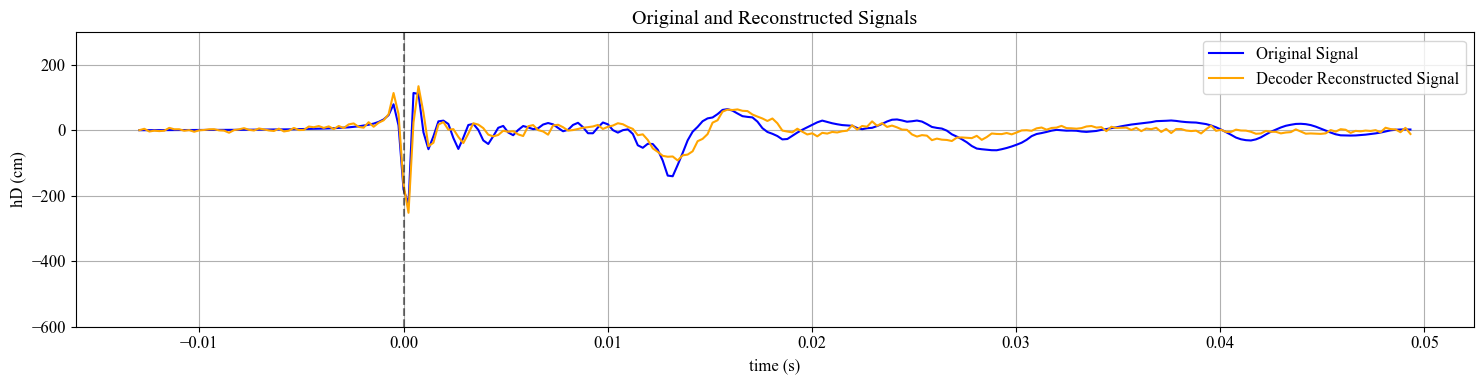

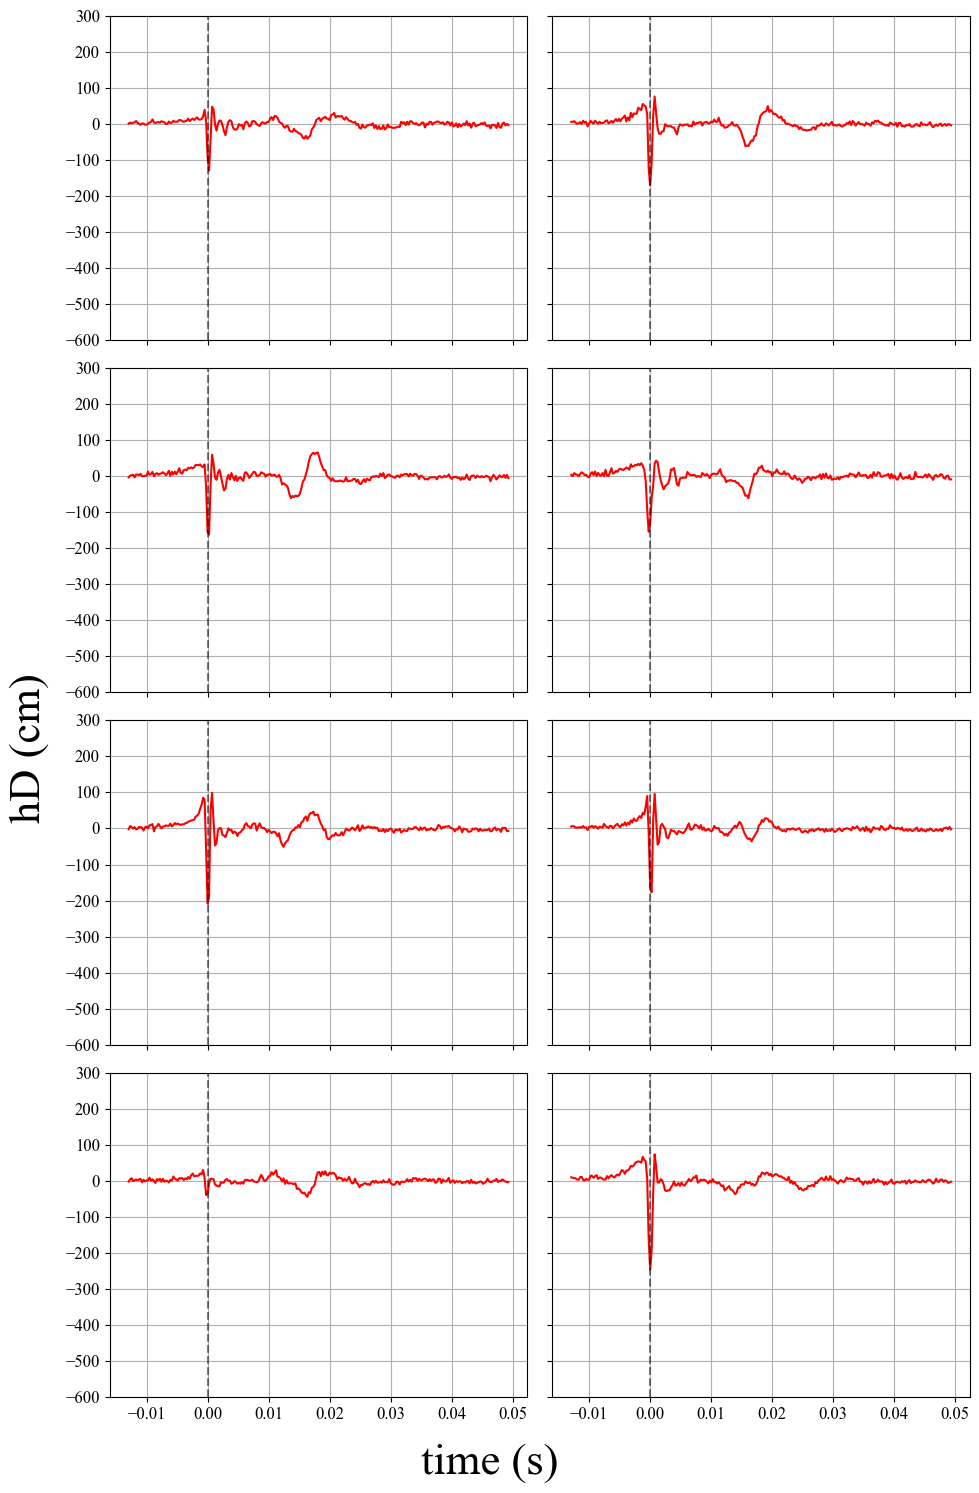

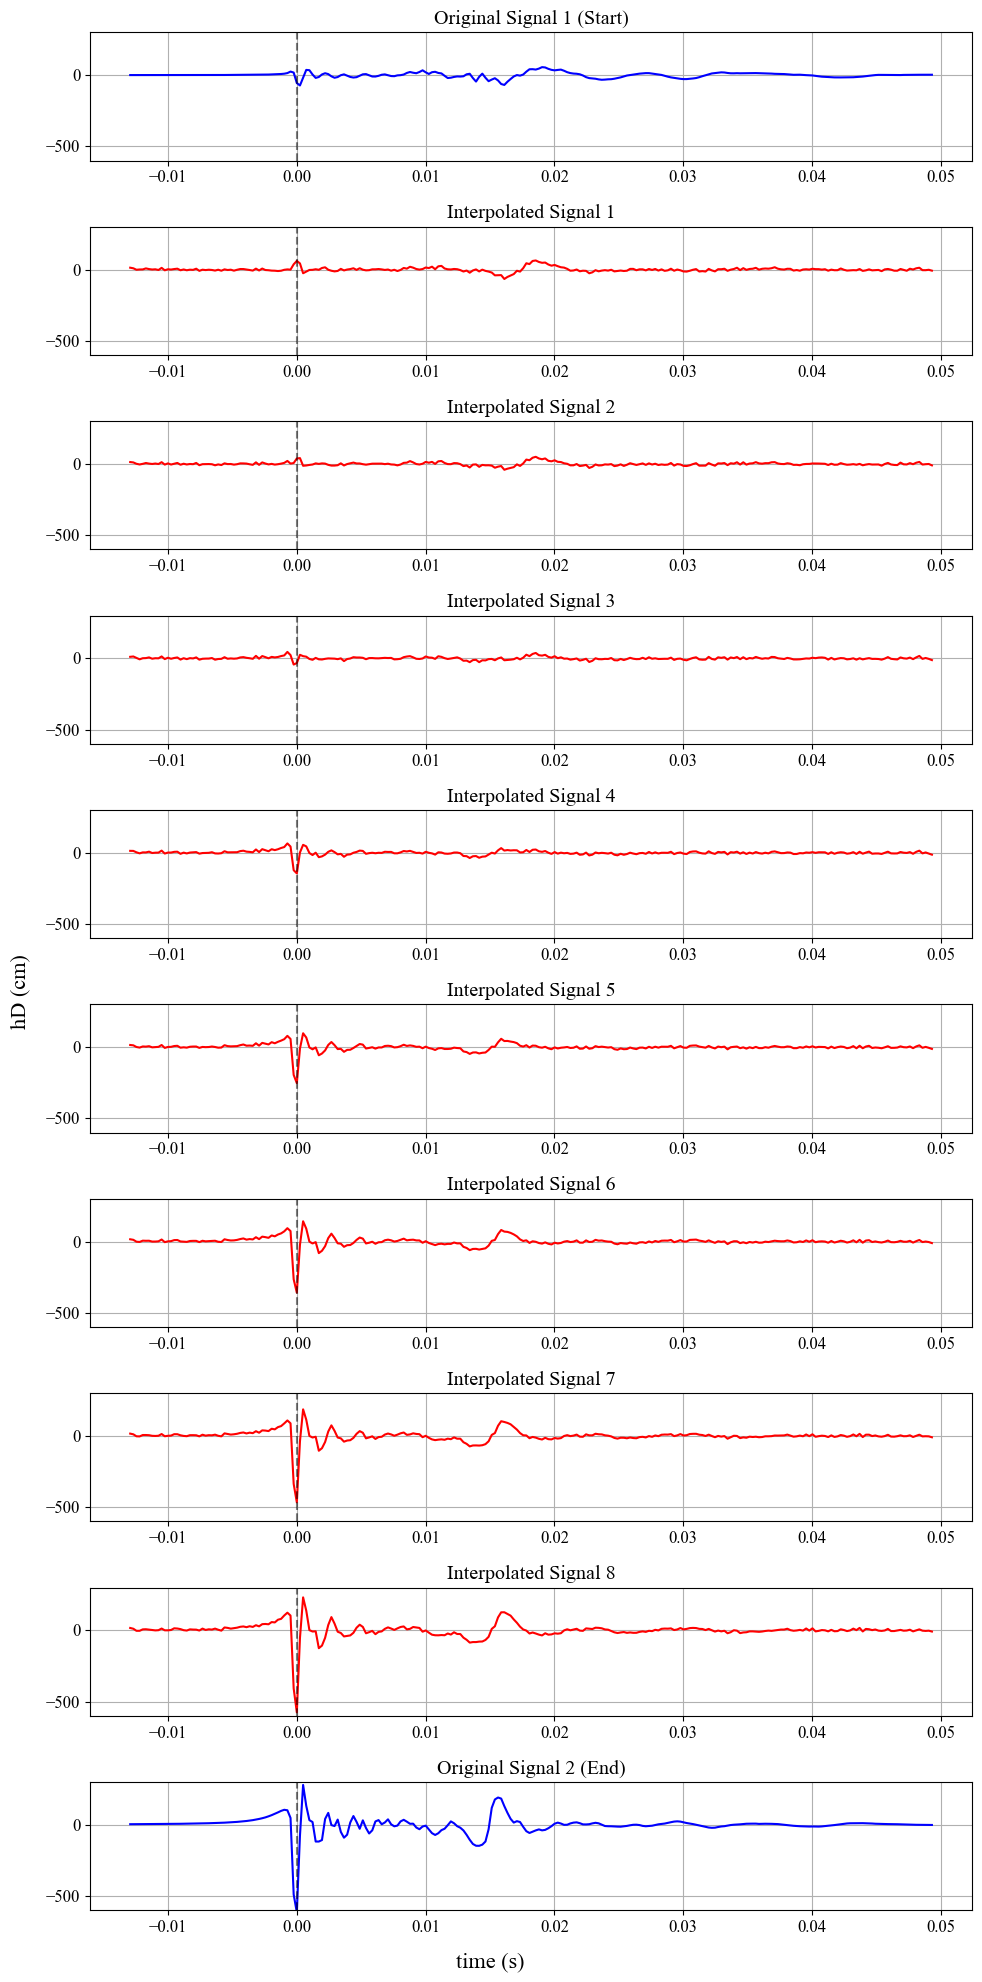

Training:   2%|▏         | 11/512 [00:09<08:20,  1.00it/s]

Epoch 11, Train Loss: 62.3425, Val Loss: 65.6637


Training:   2%|▏         | 12/512 [00:10<07:26,  1.12it/s]

Epoch 12, Train Loss: 60.4025, Val Loss: 63.6775


Training:   3%|▎         | 13/512 [00:10<06:47,  1.22it/s]

Epoch 13, Train Loss: 57.5003, Val Loss: 59.2418


Training:   3%|▎         | 14/512 [00:11<06:19,  1.31it/s]

Epoch 14, Train Loss: 54.4494, Val Loss: 57.8908


Training:   3%|▎         | 15/512 [00:11<05:58,  1.39it/s]

Epoch 15, Train Loss: 53.4718, Val Loss: 55.2894


Training:   3%|▎         | 16/512 [00:12<05:42,  1.45it/s]

Epoch 16, Train Loss: 51.7955, Val Loss: 55.3499


Training:   3%|▎         | 17/512 [00:13<05:41,  1.45it/s]

Epoch 17, Train Loss: 51.5525, Val Loss: 54.1700


Training:   4%|▎         | 18/512 [00:14<06:02,  1.36it/s]

Epoch 18, Train Loss: 50.4776, Val Loss: 52.0774


Training:   4%|▎         | 19/512 [00:15<06:25,  1.28it/s]

Epoch 19, Train Loss: 48.5615, Val Loss: 52.0535


Training:   4%|▎         | 19/512 [00:15<06:25,  1.28it/s]

Epoch 20, Train Loss: 47.5533, Val Loss: 49.8643


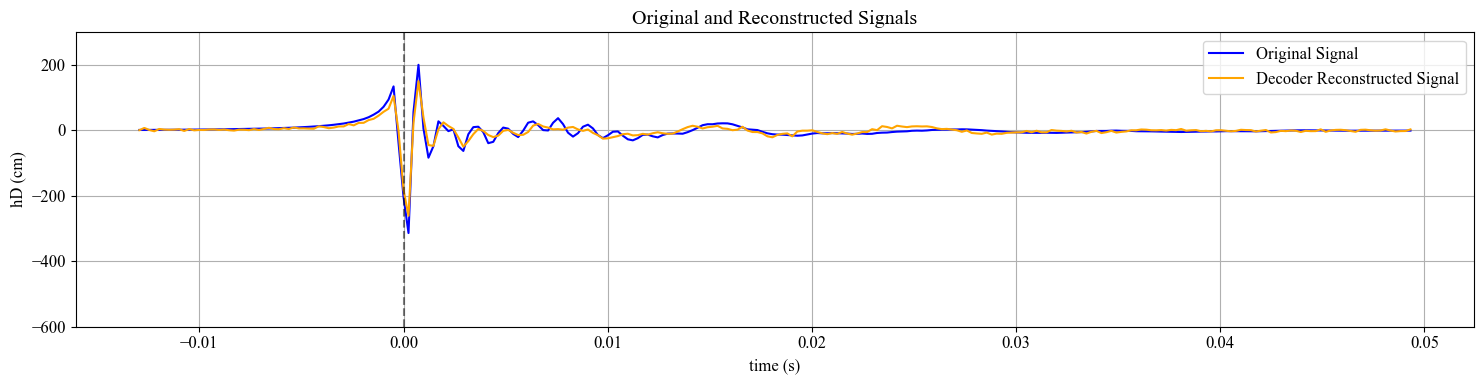

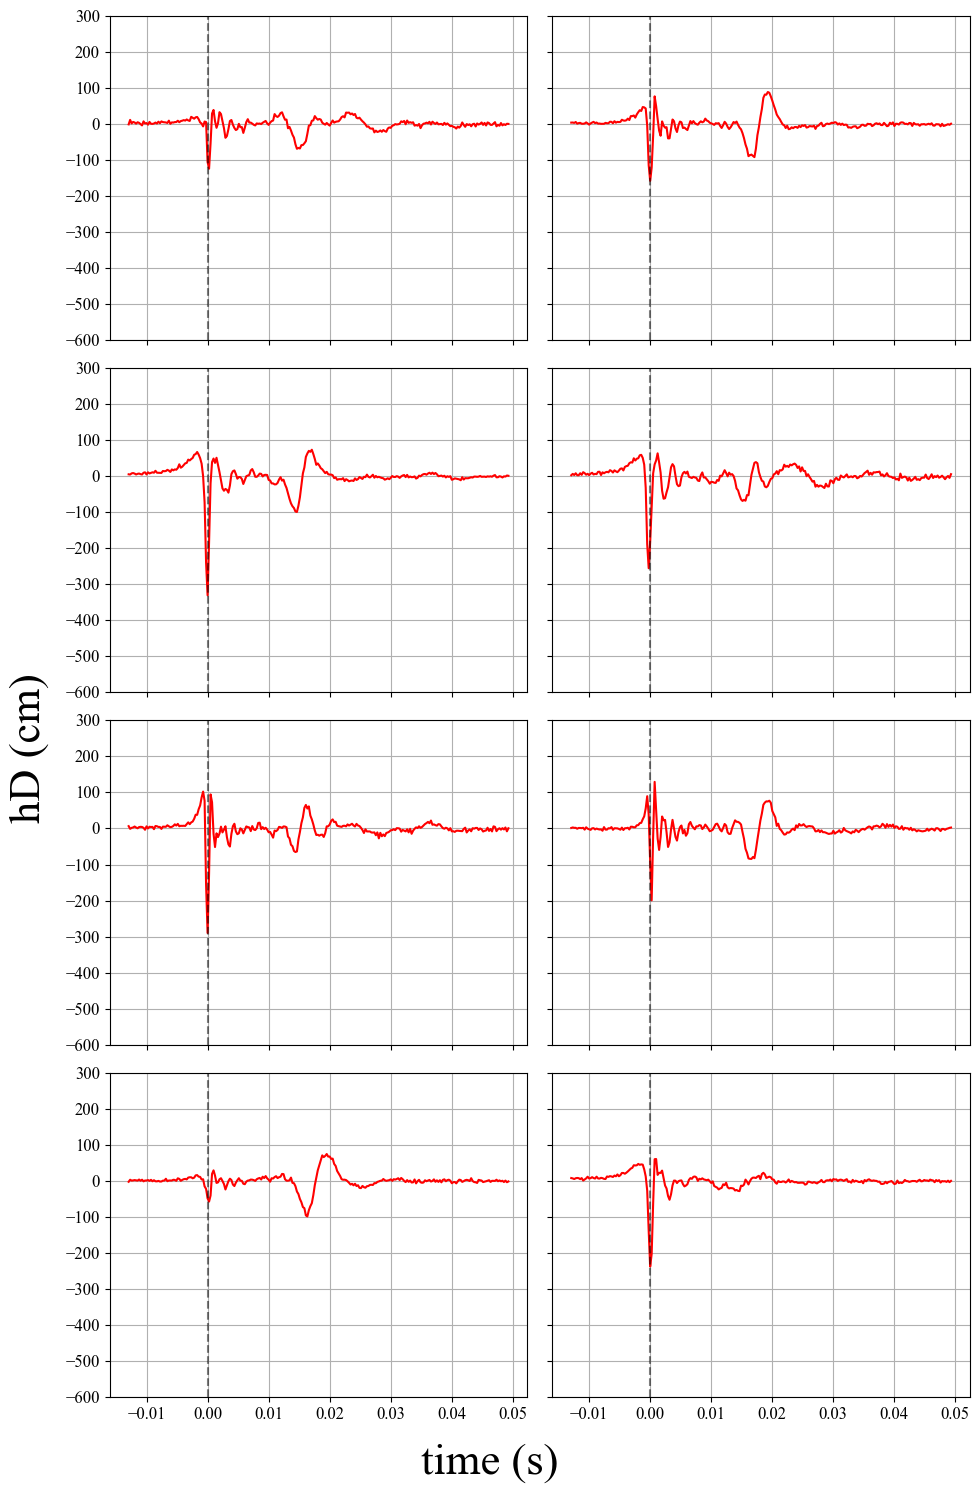

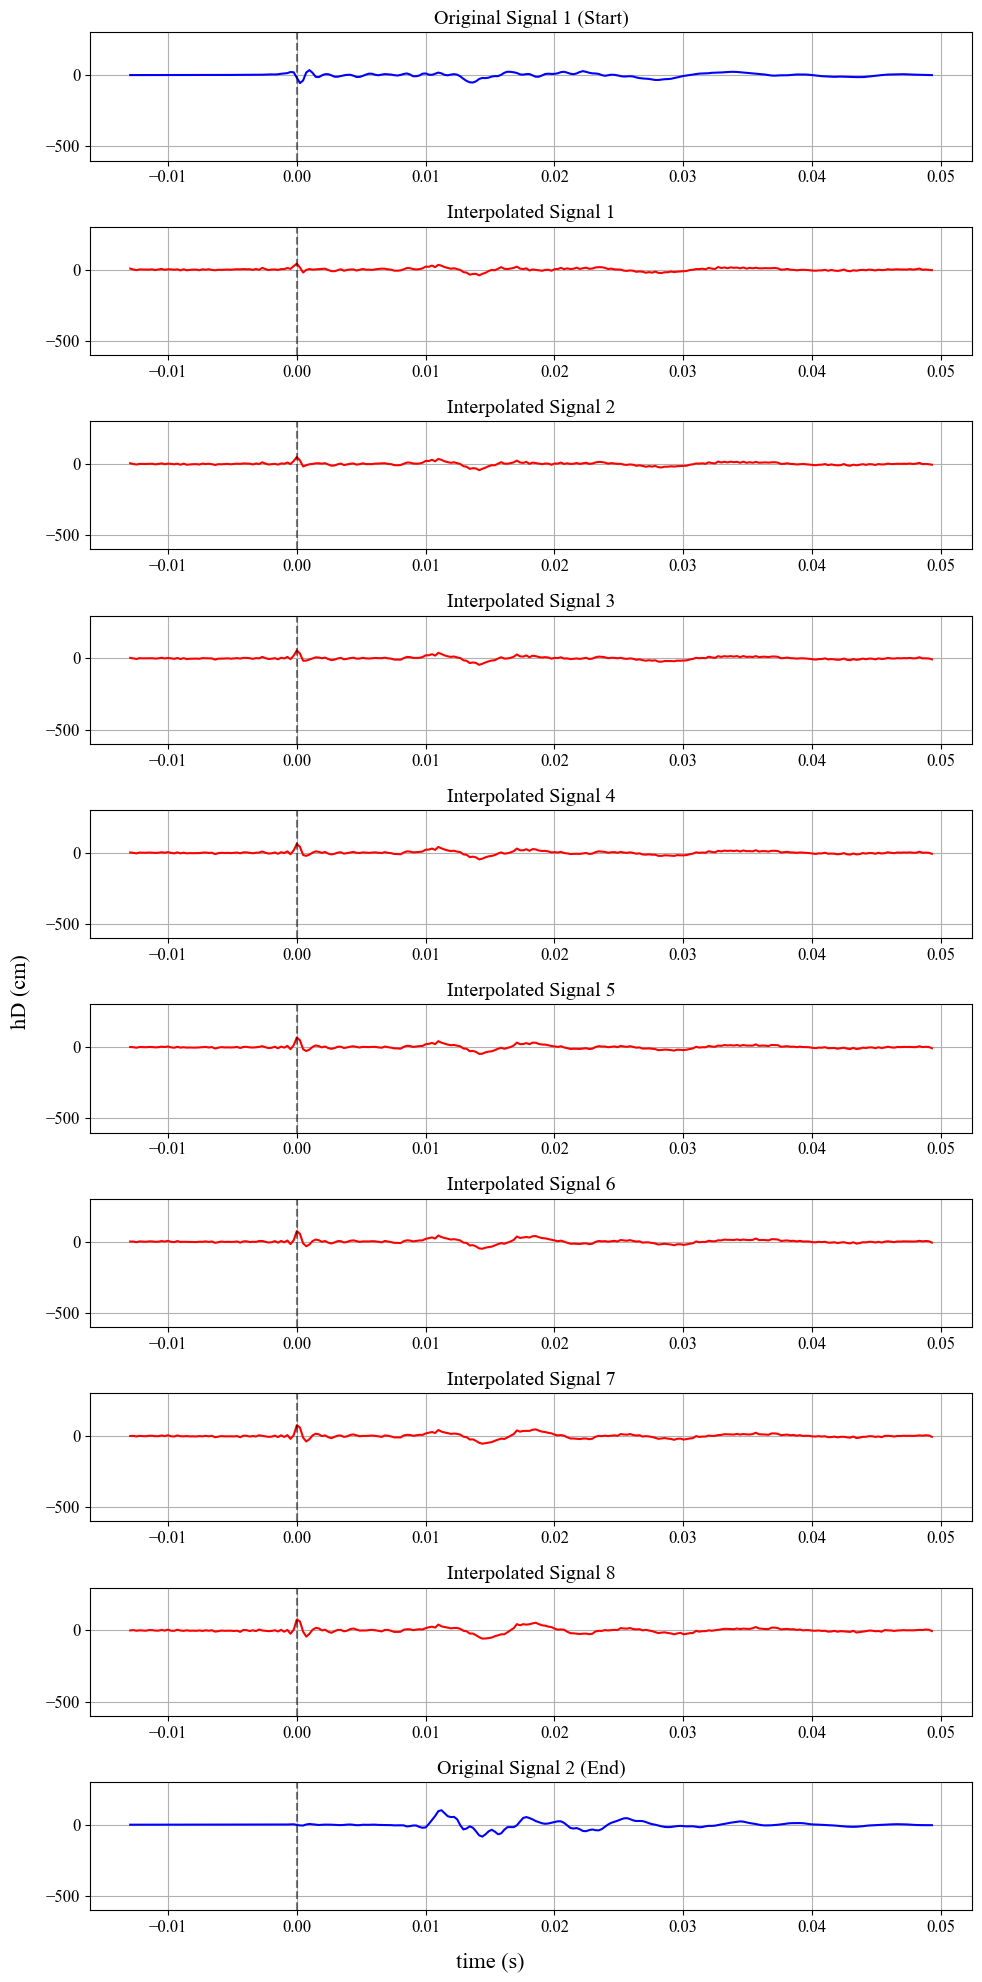

Training:   4%|▍         | 21/512 [00:18<09:39,  1.18s/it]

Epoch 21, Train Loss: 46.6447, Val Loss: 49.2489


Training:   4%|▍         | 22/512 [00:19<08:48,  1.08s/it]

Epoch 22, Train Loss: 45.3506, Val Loss: 47.5357


Training:   4%|▍         | 23/512 [00:19<07:52,  1.03it/s]

Epoch 23, Train Loss: 45.0207, Val Loss: 47.9887


Training:   5%|▍         | 24/512 [00:20<07:31,  1.08it/s]

Epoch 24, Train Loss: 44.0570, Val Loss: 46.8567


Training:   5%|▍         | 25/512 [00:21<07:11,  1.13it/s]

Epoch 25, Train Loss: 43.5241, Val Loss: 46.7780


Training:   5%|▌         | 26/512 [00:22<06:38,  1.22it/s]

Epoch 26, Train Loss: 43.9281, Val Loss: 47.8929


Training:   5%|▌         | 27/512 [00:23<06:32,  1.24it/s]

Epoch 27, Train Loss: 43.0086, Val Loss: 45.7546


Training:   5%|▌         | 28/512 [00:23<06:22,  1.27it/s]

Epoch 28, Train Loss: 42.2934, Val Loss: 45.7421


Training:   6%|▌         | 29/512 [00:24<06:01,  1.33it/s]

Epoch 29, Train Loss: 41.8345, Val Loss: 45.1587


Training:   6%|▌         | 29/512 [00:25<06:01,  1.33it/s]

Epoch 30, Train Loss: 41.3406, Val Loss: 44.5958


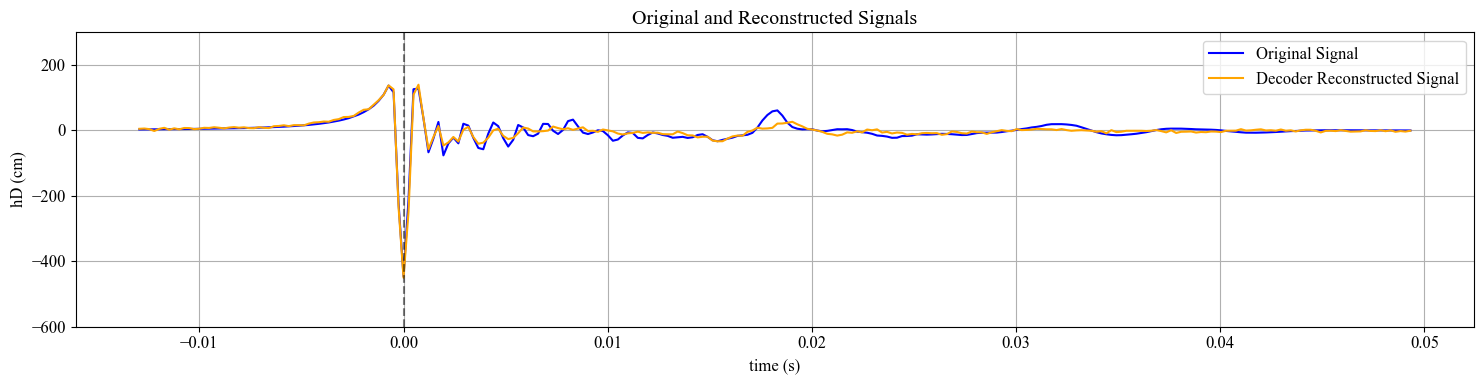

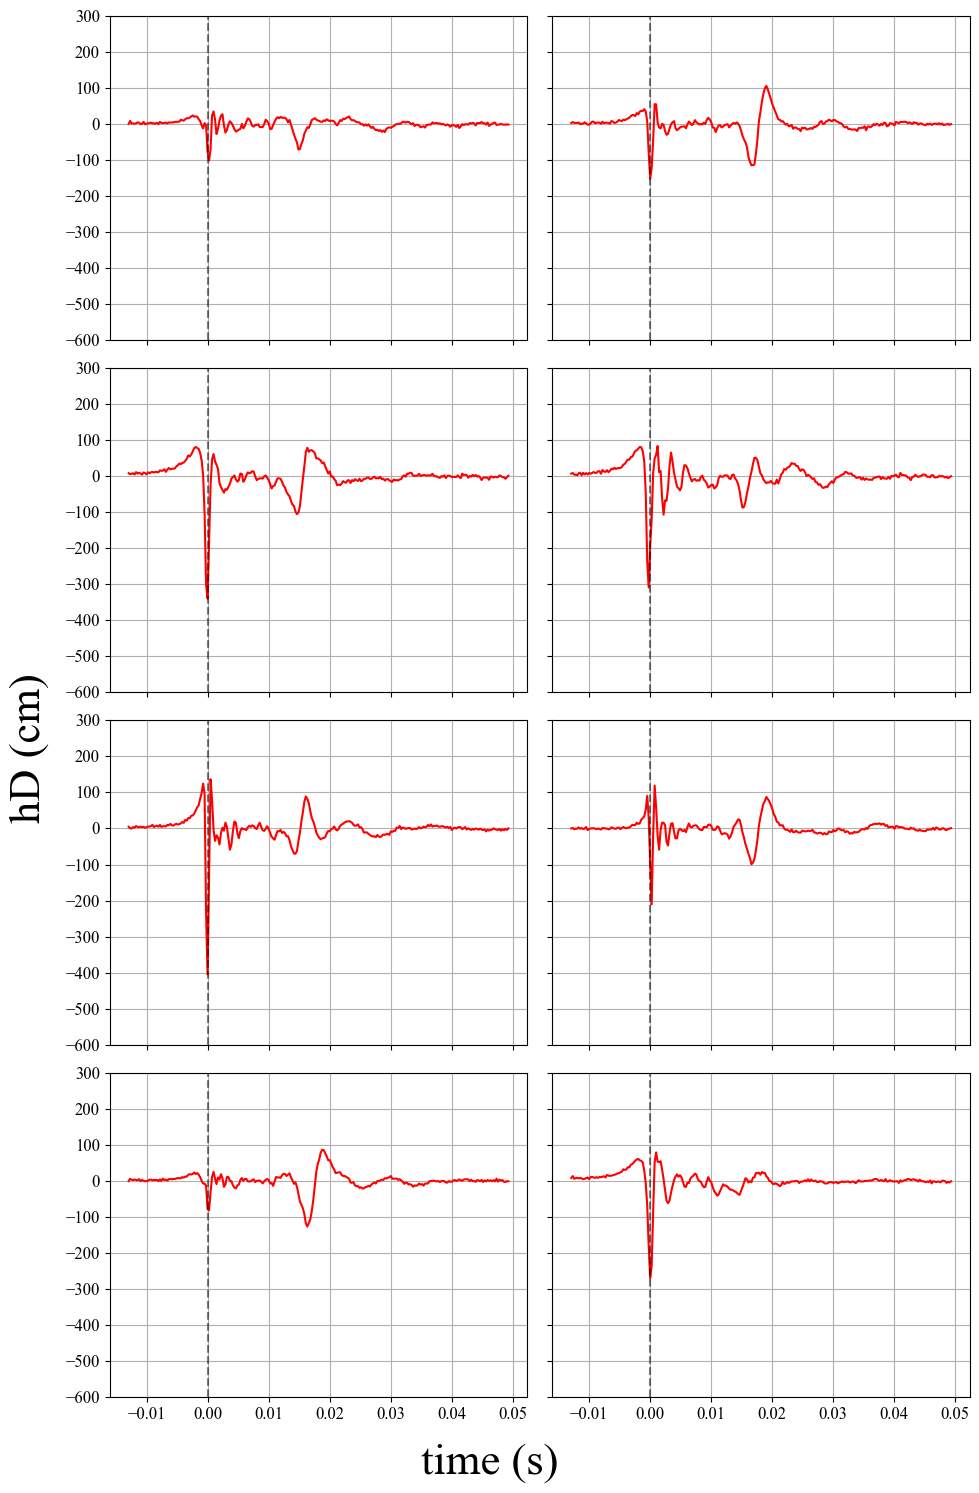

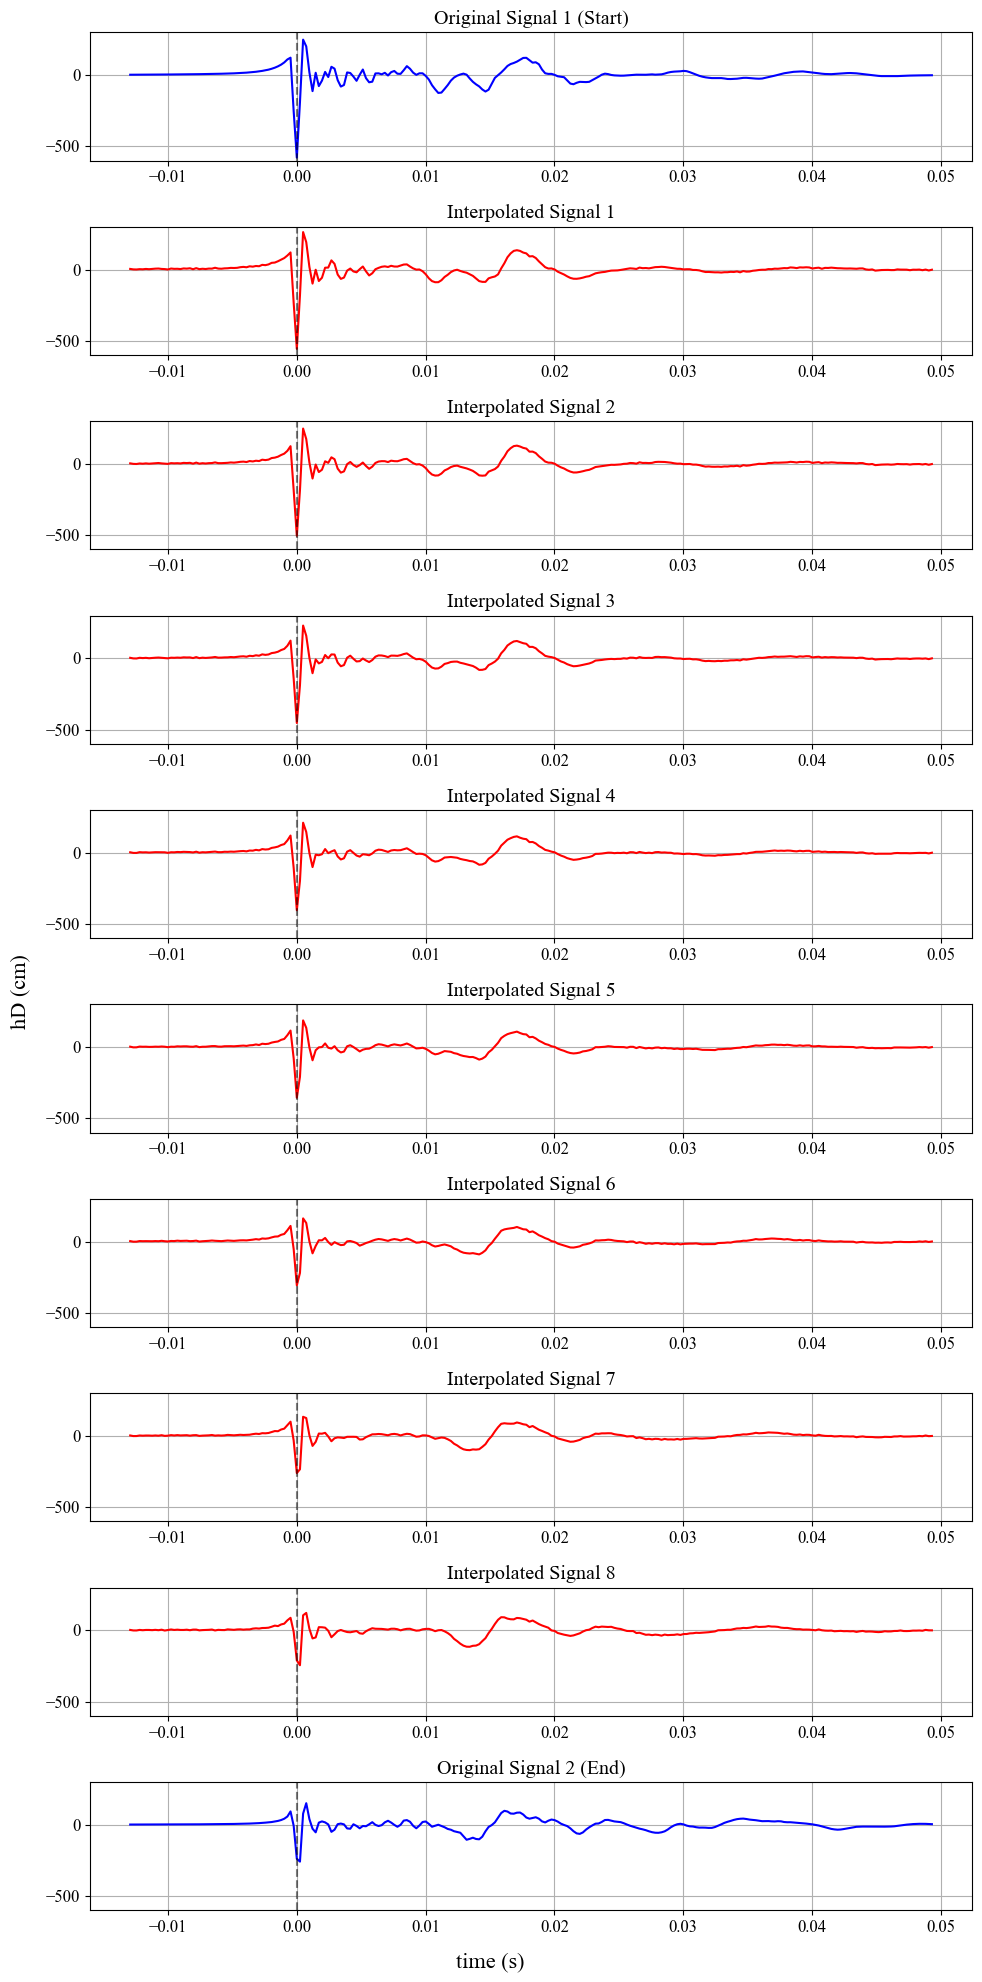

Training:   6%|▌         | 31/512 [00:27<08:08,  1.01s/it]

Epoch 31, Train Loss: 41.5153, Val Loss: 43.9330


Training:   6%|▋         | 32/512 [00:27<07:36,  1.05it/s]

Epoch 32, Train Loss: 40.7492, Val Loss: 44.0543


Training:   6%|▋         | 33/512 [00:28<06:56,  1.15it/s]

Epoch 33, Train Loss: 40.7413, Val Loss: 44.8368


Training:   7%|▋         | 34/512 [00:29<06:32,  1.22it/s]

Epoch 34, Train Loss: 40.7620, Val Loss: 43.0388


Training:   7%|▋         | 35/512 [00:30<06:13,  1.28it/s]

Epoch 35, Train Loss: 40.1423, Val Loss: 42.6392


Training:   7%|▋         | 36/512 [00:30<06:10,  1.29it/s]

Epoch 36, Train Loss: 39.5366, Val Loss: 43.9449


Training:   7%|▋         | 37/512 [00:31<06:09,  1.28it/s]

Epoch 37, Train Loss: 39.4693, Val Loss: 42.8321


Training:   7%|▋         | 38/512 [00:32<06:09,  1.28it/s]

Epoch 38, Train Loss: 39.2857, Val Loss: 42.3064


Training:   8%|▊         | 39/512 [00:33<06:03,  1.30it/s]

Epoch 39, Train Loss: 38.9977, Val Loss: 42.9262


Training:   8%|▊         | 39/512 [00:33<06:03,  1.30it/s]

Epoch 40, Train Loss: 38.8584, Val Loss: 41.9656


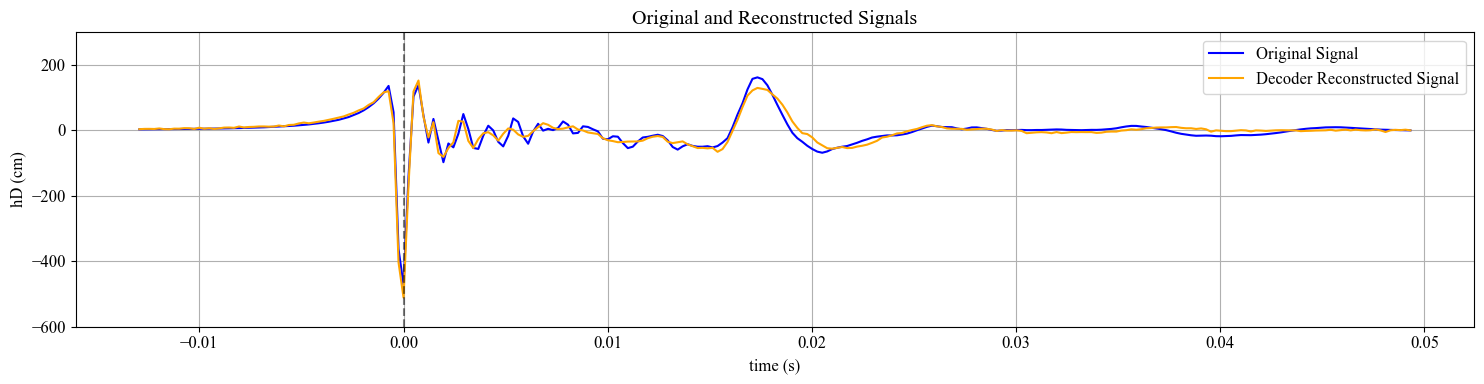

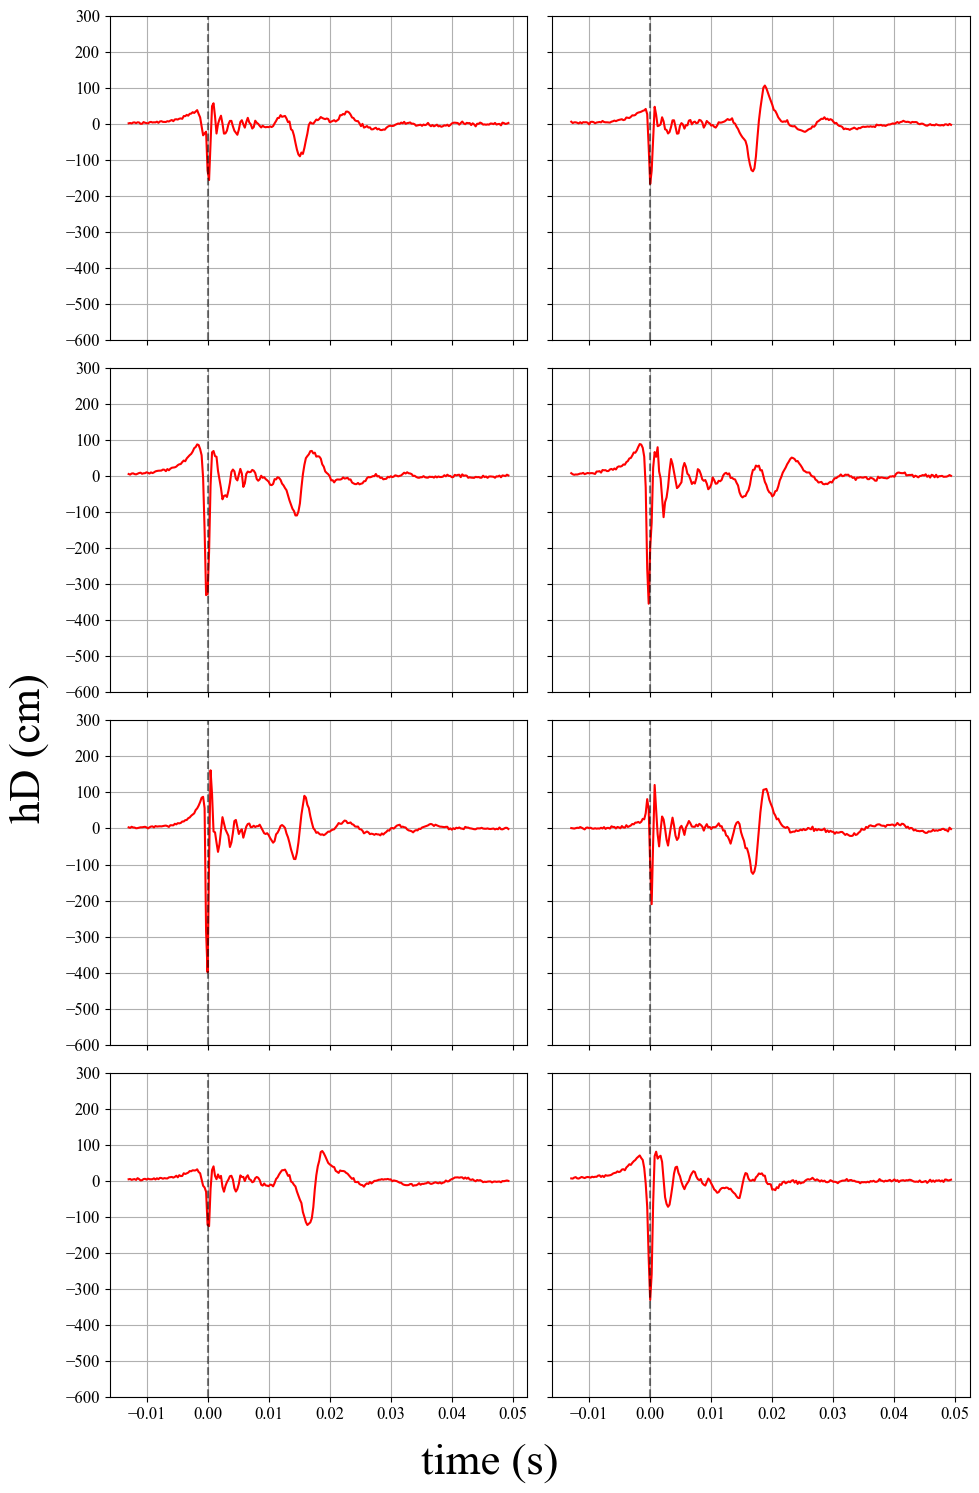

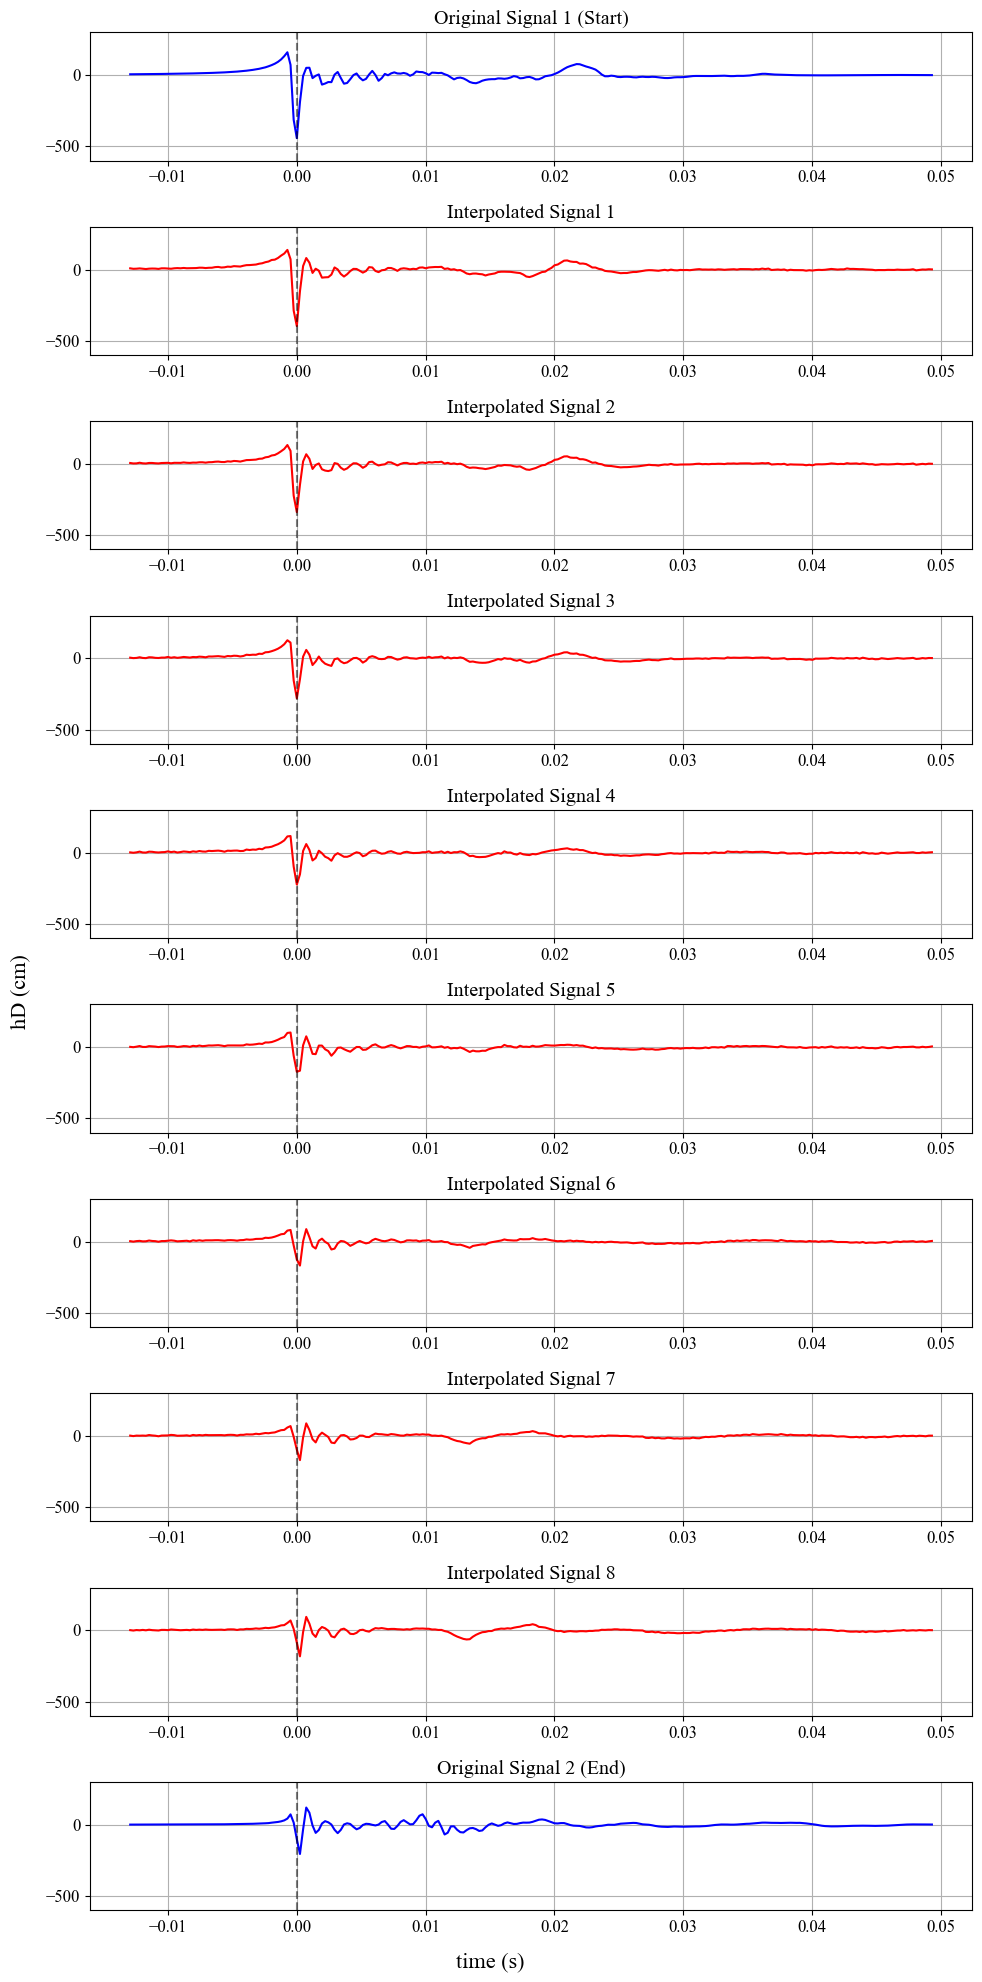

Training:   8%|▊         | 41/512 [00:36<08:36,  1.10s/it]

Epoch 41, Train Loss: 38.4778, Val Loss: 43.1979


Training:   8%|▊         | 42/512 [00:36<07:36,  1.03it/s]

Epoch 42, Train Loss: 38.4573, Val Loss: 43.0428


Training:   8%|▊         | 43/512 [00:37<06:50,  1.14it/s]

Epoch 43, Train Loss: 38.0774, Val Loss: 41.9967


Training:   9%|▊         | 44/512 [00:38<06:23,  1.22it/s]

Epoch 44, Train Loss: 38.1680, Val Loss: 41.5314


Training:   9%|▉         | 45/512 [00:38<05:59,  1.30it/s]

Epoch 45, Train Loss: 38.0574, Val Loss: 41.3631


Training:   9%|▉         | 46/512 [00:39<05:48,  1.34it/s]

Epoch 46, Train Loss: 37.8789, Val Loss: 42.5213


Training:   9%|▉         | 47/512 [00:40<05:47,  1.34it/s]

Epoch 47, Train Loss: 38.1817, Val Loss: 43.7185


Training:   9%|▉         | 48/512 [00:41<05:48,  1.33it/s]

Epoch 48, Train Loss: 37.7665, Val Loss: 42.2827


Training:  10%|▉         | 49/512 [00:41<05:37,  1.37it/s]

Epoch 49, Train Loss: 37.5041, Val Loss: 41.4986


Training:  10%|▉         | 49/512 [00:42<05:37,  1.37it/s]

Epoch 50, Train Loss: 37.0794, Val Loss: 42.4384


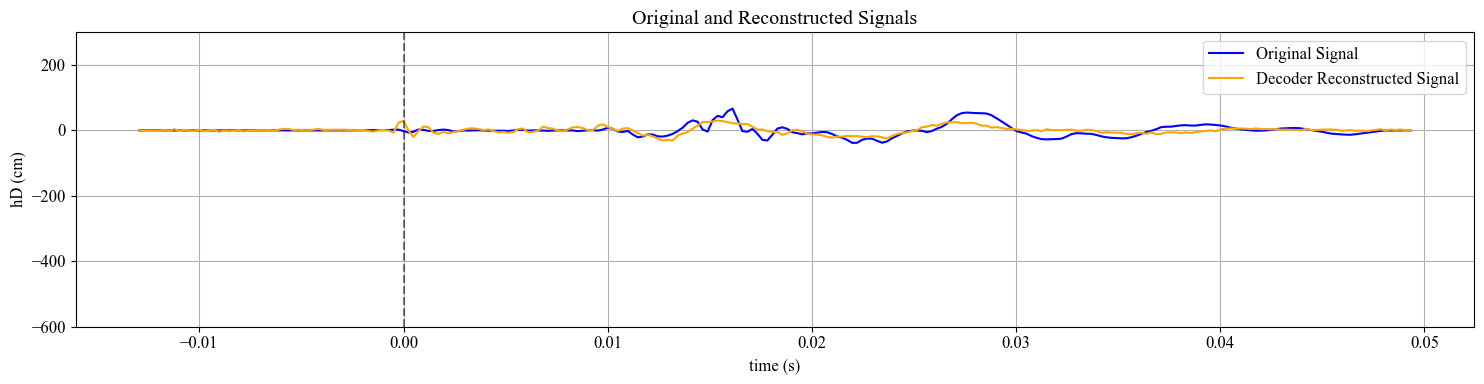

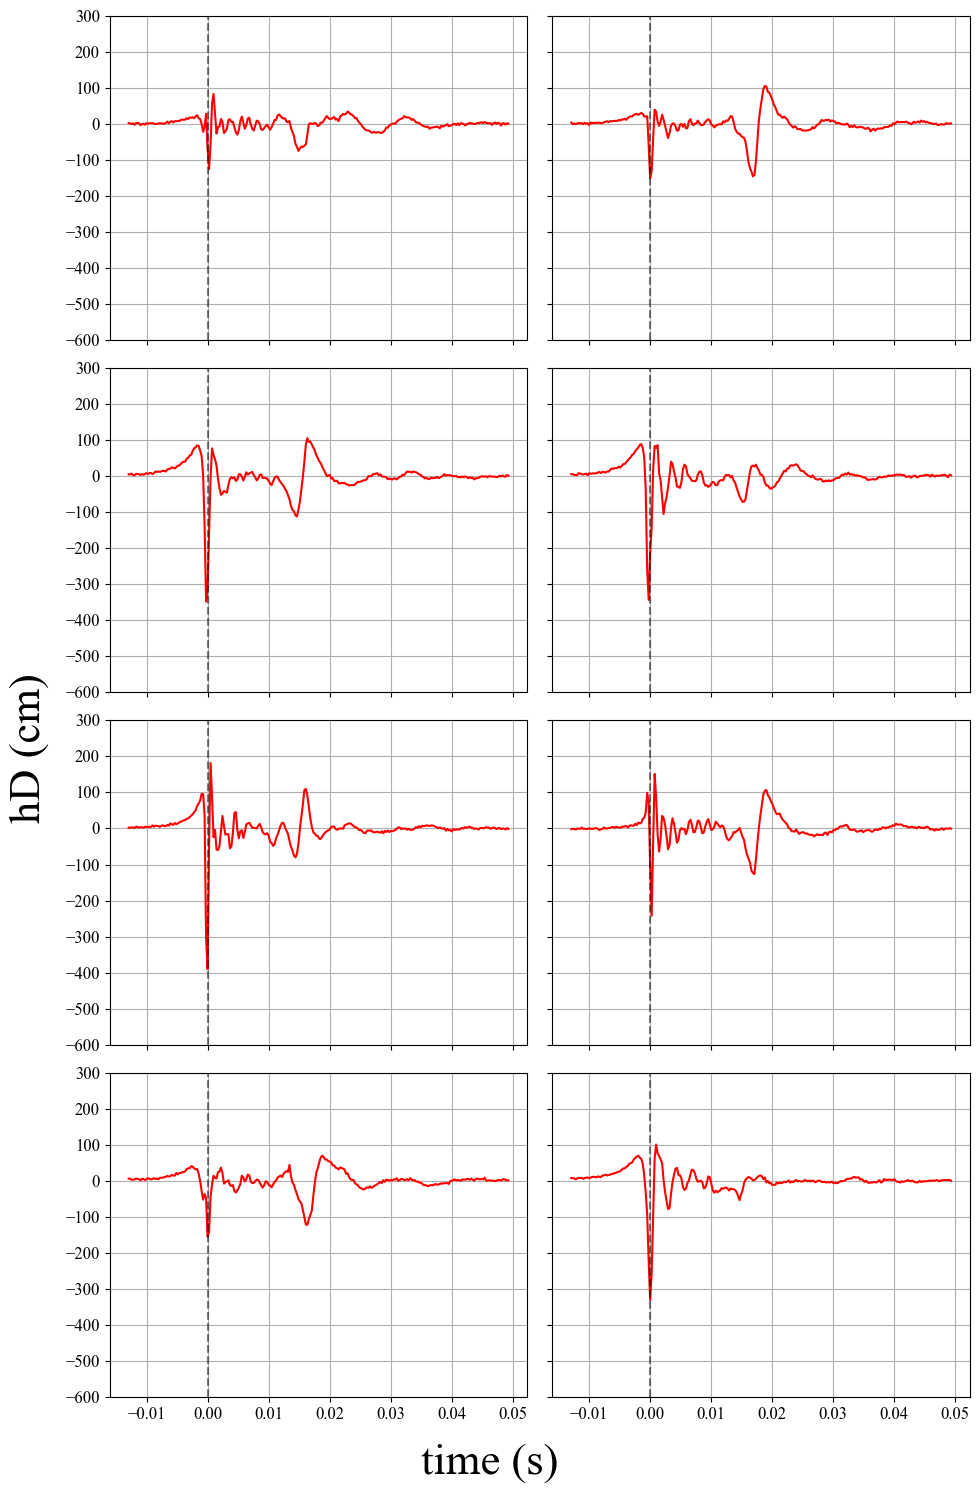

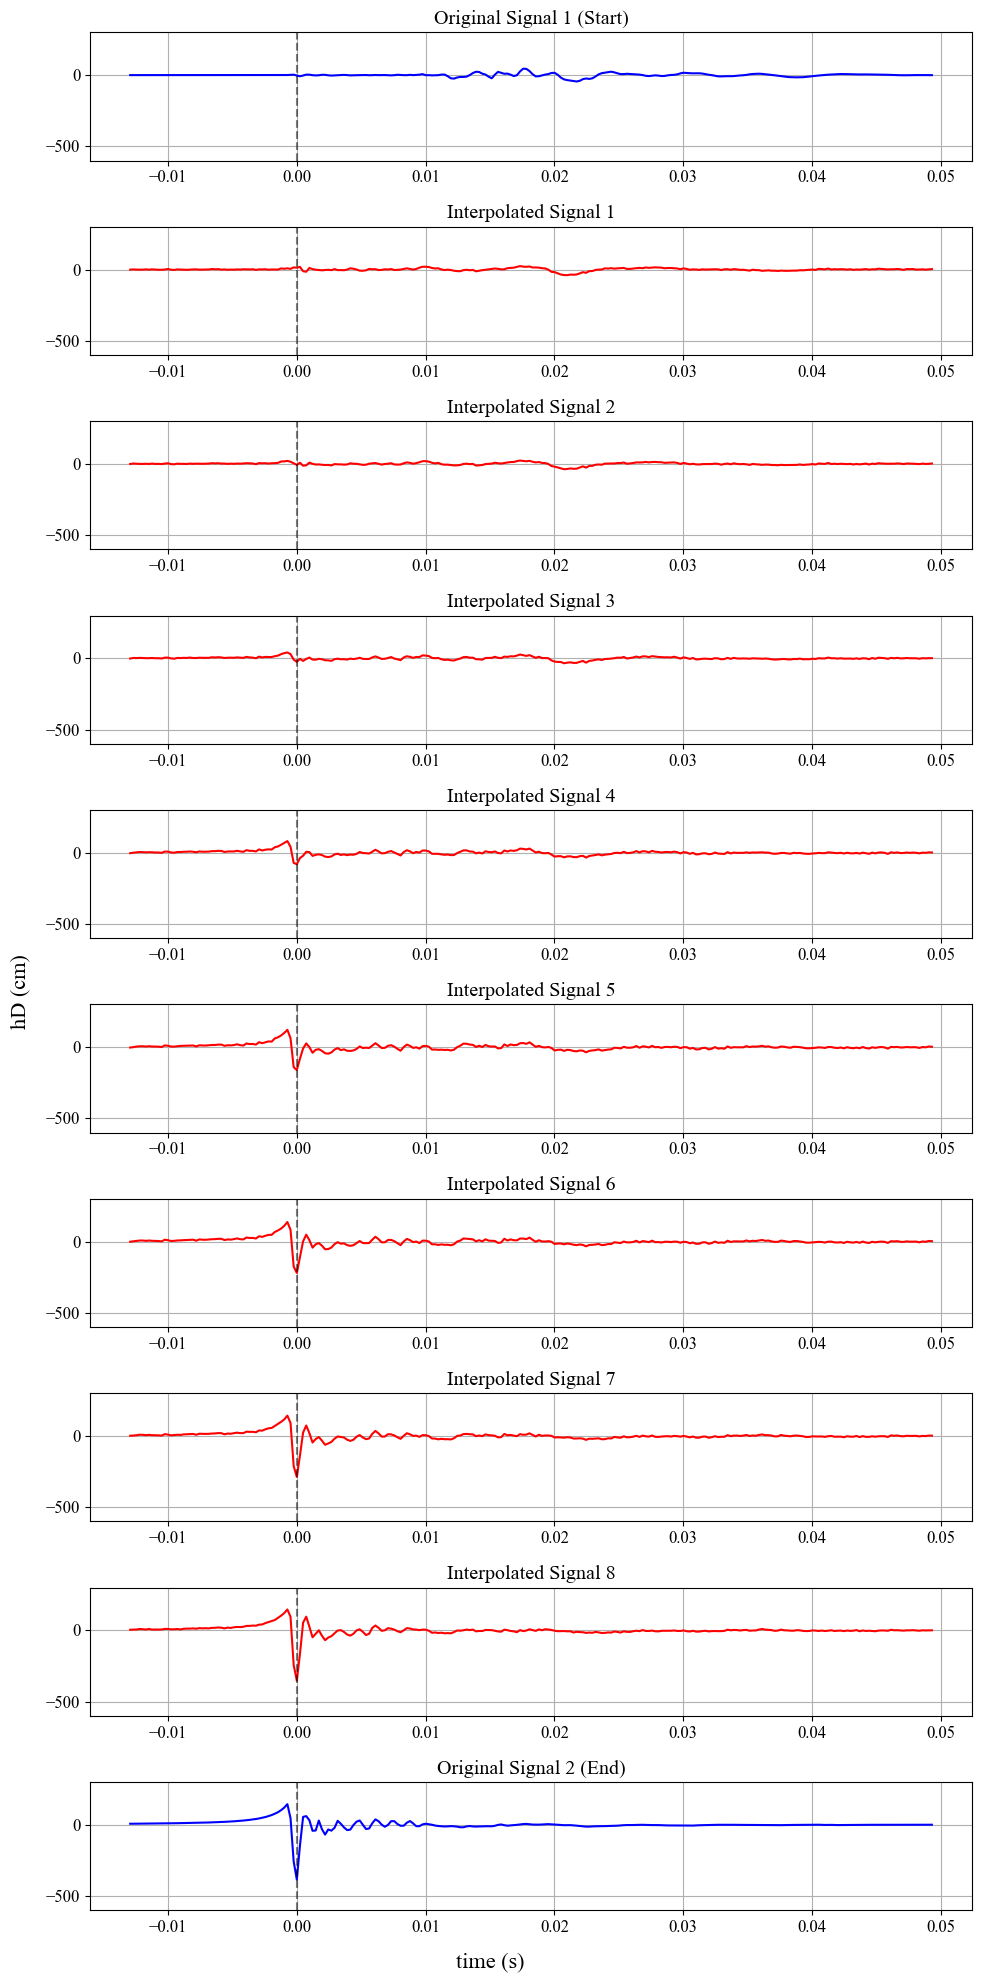

Training:  10%|▉         | 51/512 [00:44<07:51,  1.02s/it]

Epoch 51, Train Loss: 37.3635, Val Loss: 41.5161


Training:  10%|█         | 52/512 [00:45<07:02,  1.09it/s]

Epoch 52, Train Loss: 36.8661, Val Loss: 41.0360


Training:  10%|█         | 53/512 [00:46<06:33,  1.17it/s]

Epoch 53, Train Loss: 36.6961, Val Loss: 40.7233


Training:  11%|█         | 54/512 [00:46<06:02,  1.26it/s]

Epoch 54, Train Loss: 36.3395, Val Loss: 40.3476


Training:  11%|█         | 55/512 [00:47<06:59,  1.09it/s]

Epoch 55, Train Loss: 36.0907, Val Loss: 41.1185


Training:  11%|█         | 56/512 [00:48<06:50,  1.11it/s]

Epoch 56, Train Loss: 36.1239, Val Loss: 40.8809


Training:  11%|█         | 57/512 [00:49<06:20,  1.20it/s]

Epoch 57, Train Loss: 36.0871, Val Loss: 40.4482


Training:  11%|█▏        | 58/512 [00:50<05:59,  1.26it/s]

Epoch 58, Train Loss: 36.0738, Val Loss: 41.0906


Training:  12%|█▏        | 59/512 [00:50<05:41,  1.33it/s]

Epoch 59, Train Loss: 35.5365, Val Loss: 39.9124


Training:  12%|█▏        | 59/512 [00:51<05:41,  1.33it/s]

Epoch 60, Train Loss: 35.5558, Val Loss: 40.8888


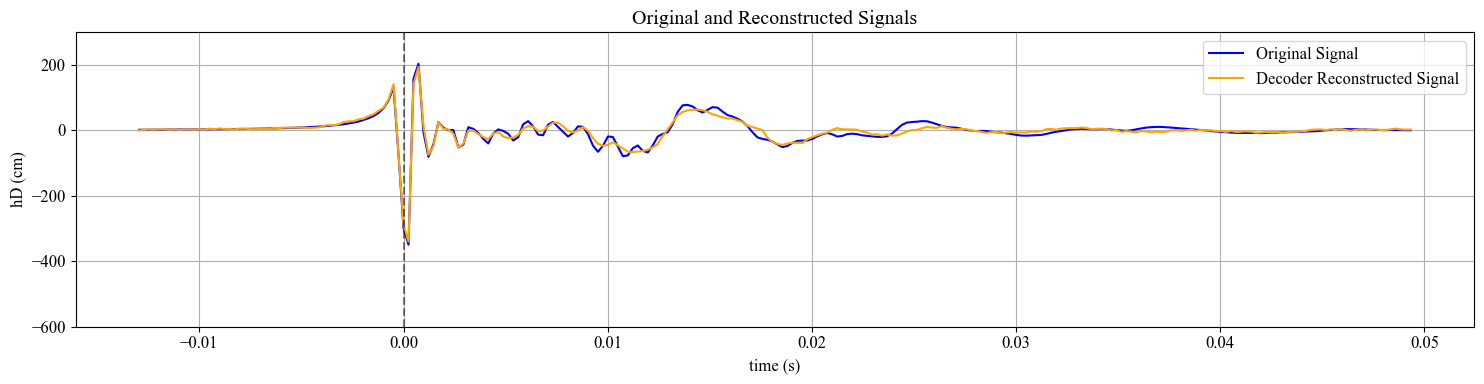

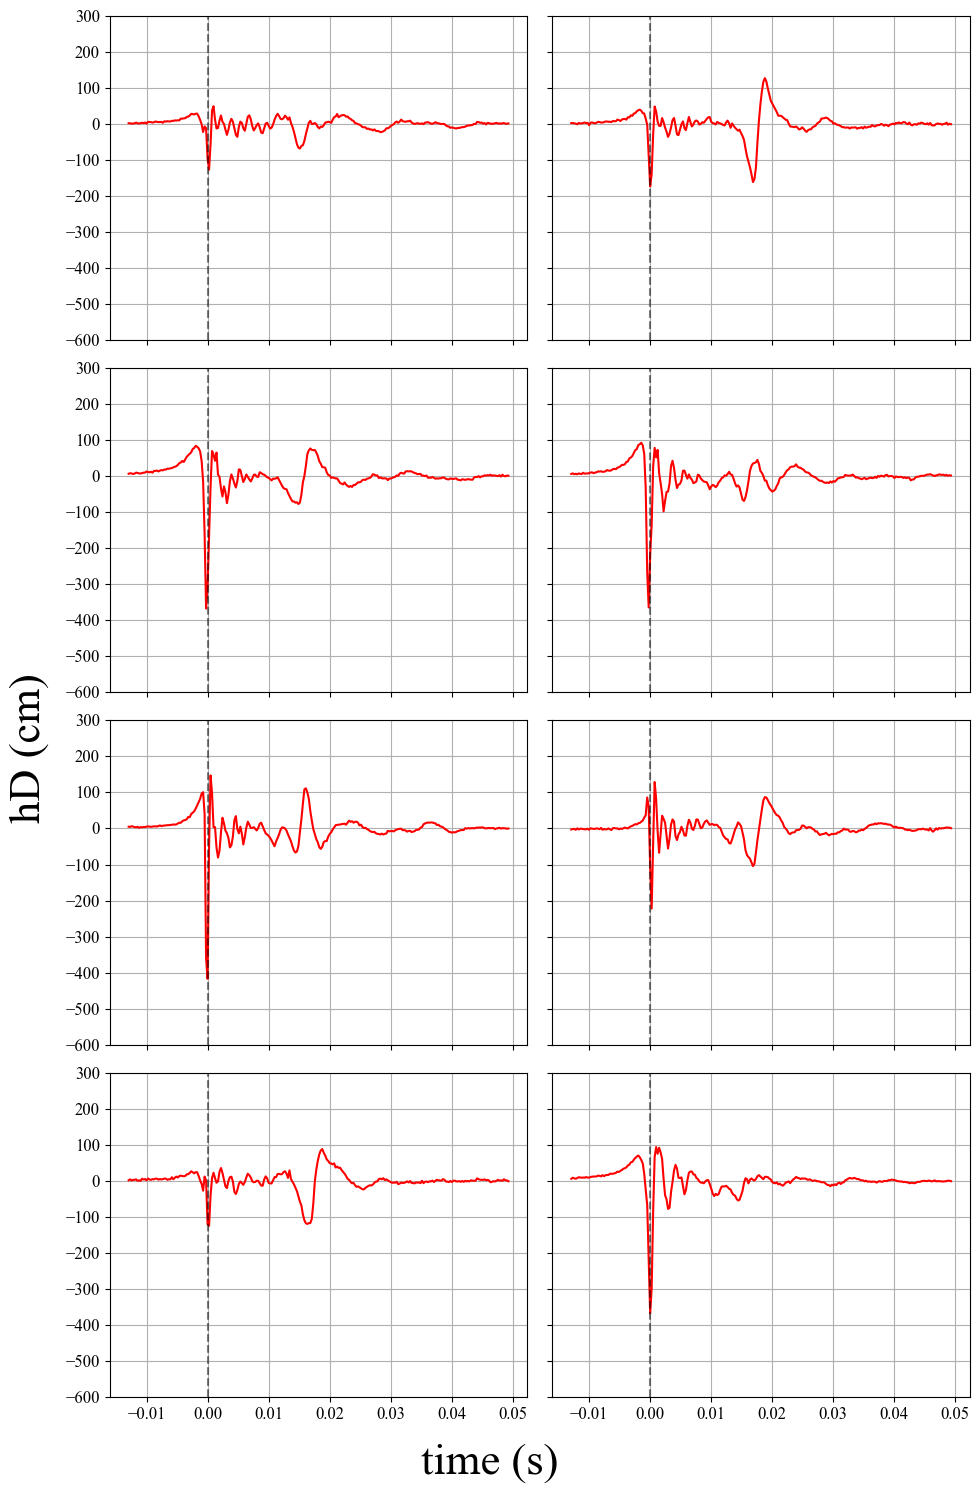

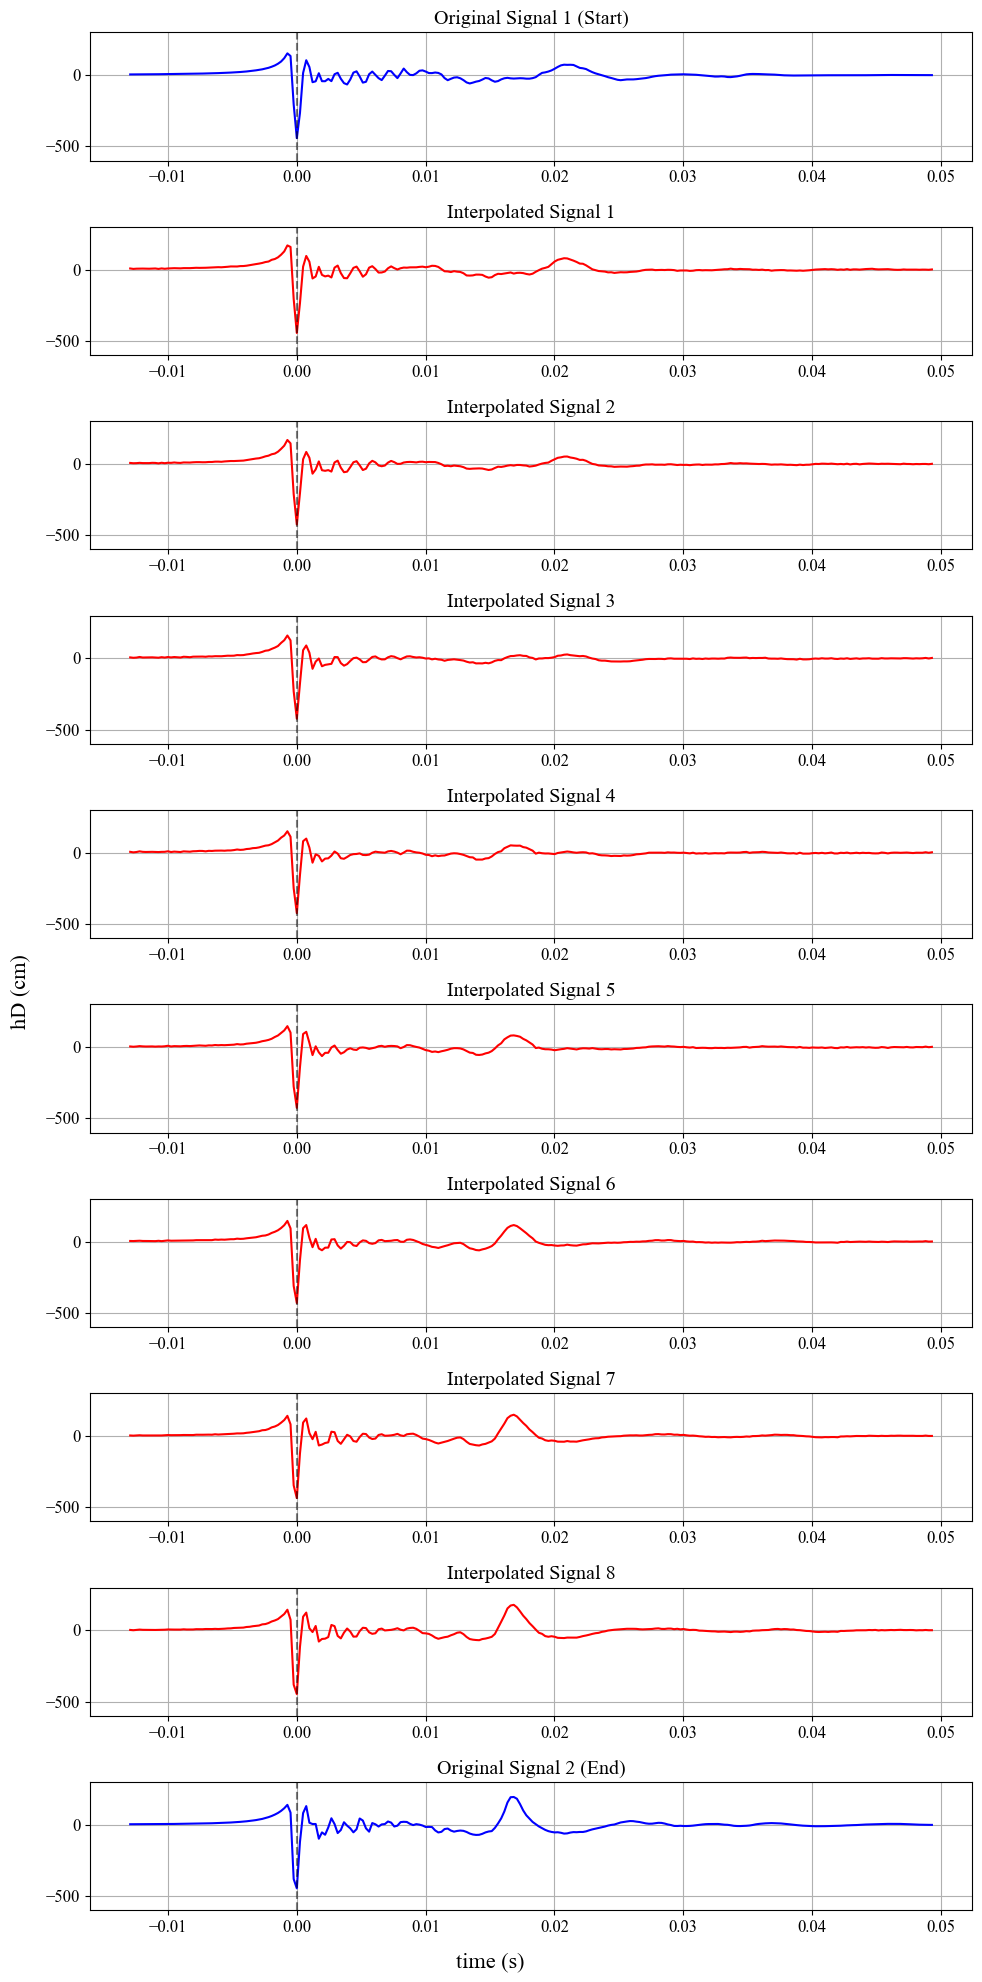

Training:  12%|█▏        | 61/512 [00:53<07:33,  1.00s/it]

Epoch 61, Train Loss: 35.8505, Val Loss: 39.3280


Training:  12%|█▏        | 62/512 [00:54<06:55,  1.08it/s]

Epoch 62, Train Loss: 35.9075, Val Loss: 39.1012


Training:  12%|█▏        | 63/512 [00:54<06:21,  1.18it/s]

Epoch 63, Train Loss: 35.2643, Val Loss: 39.6835


Training:  12%|█▎        | 64/512 [00:55<05:56,  1.26it/s]

Epoch 64, Train Loss: 35.4707, Val Loss: 39.3518


Training:  13%|█▎        | 65/512 [00:56<05:45,  1.29it/s]

Epoch 65, Train Loss: 35.2606, Val Loss: 39.1716


Training:  13%|█▎        | 66/512 [00:57<05:40,  1.31it/s]

Epoch 66, Train Loss: 34.8271, Val Loss: 39.5426


Training:  13%|█▎        | 67/512 [00:57<05:23,  1.38it/s]

Epoch 67, Train Loss: 34.6034, Val Loss: 38.8693


Training:  13%|█▎        | 68/512 [00:58<05:18,  1.40it/s]

Epoch 68, Train Loss: 34.4801, Val Loss: 39.5914


Training:  13%|█▎        | 69/512 [00:59<05:10,  1.43it/s]

Epoch 69, Train Loss: 34.8207, Val Loss: 39.4305


Training:  13%|█▎        | 69/512 [00:59<05:10,  1.43it/s]

Epoch 70, Train Loss: 34.2576, Val Loss: 39.1198


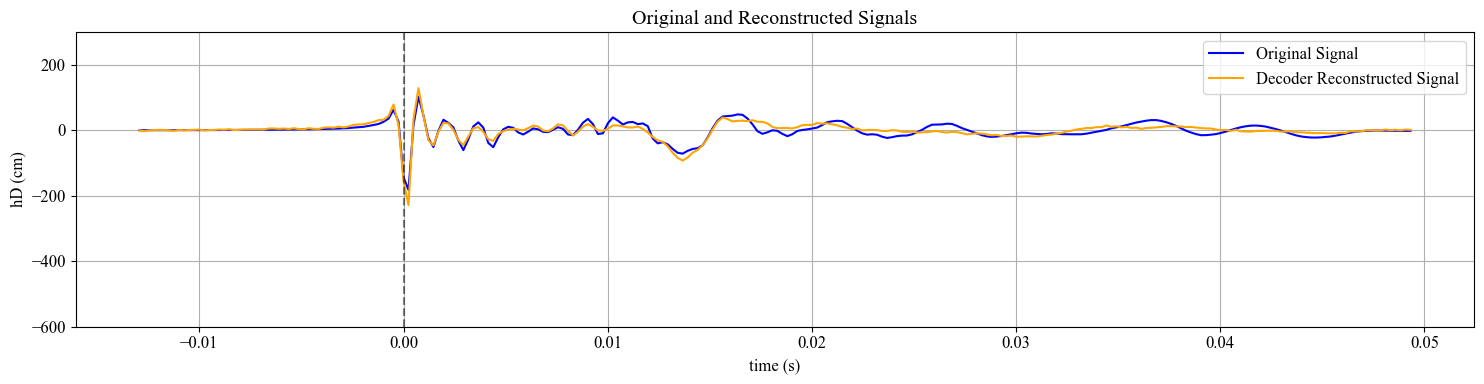

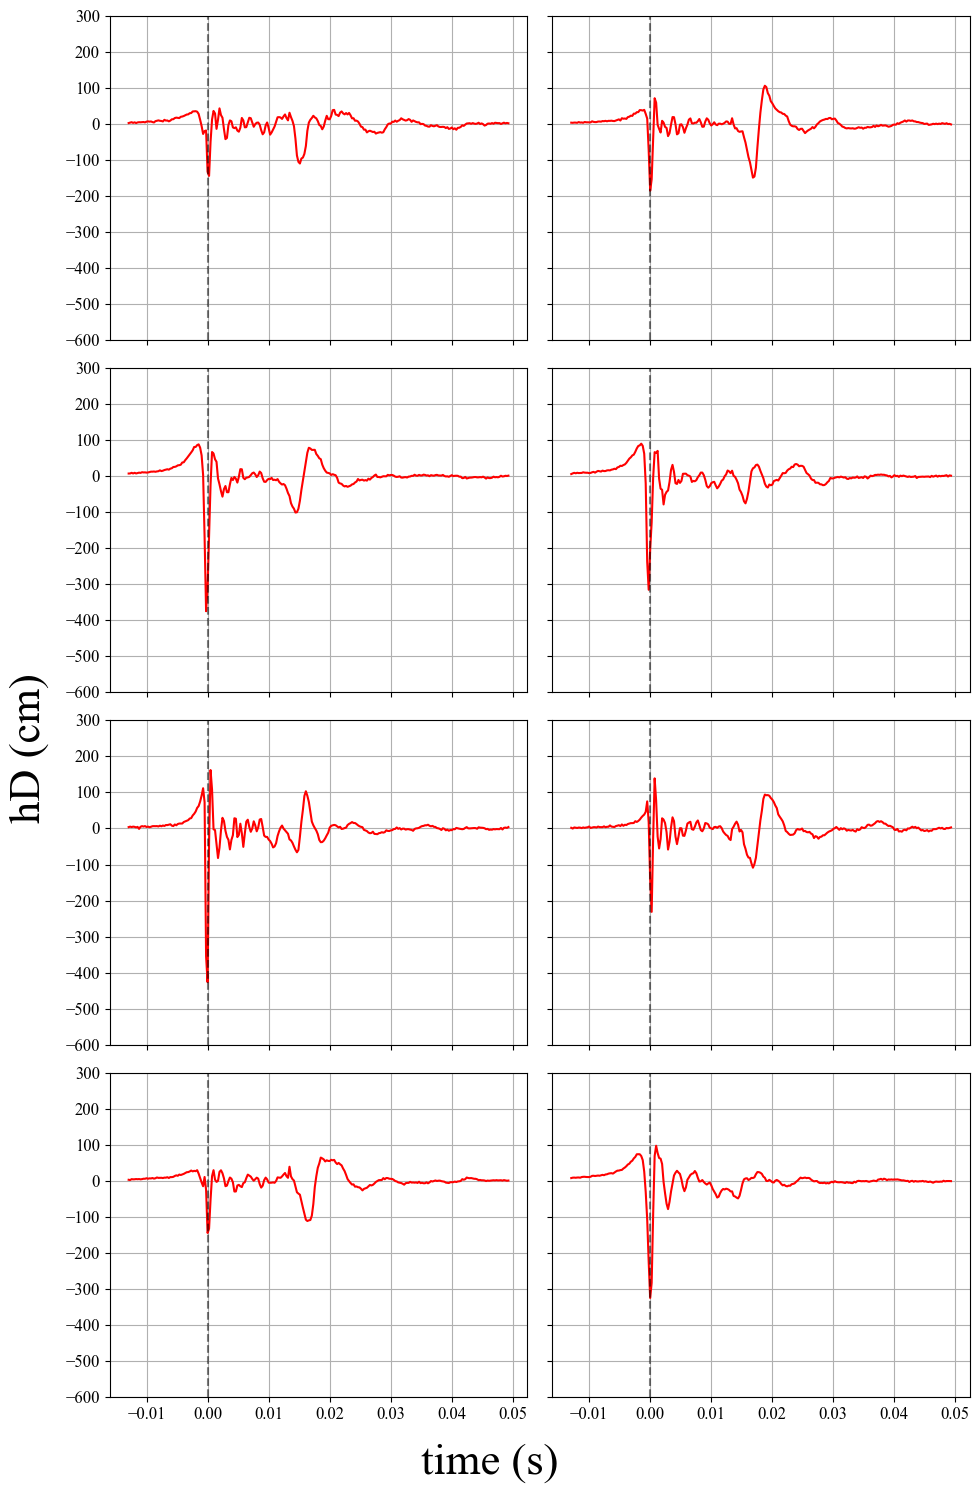

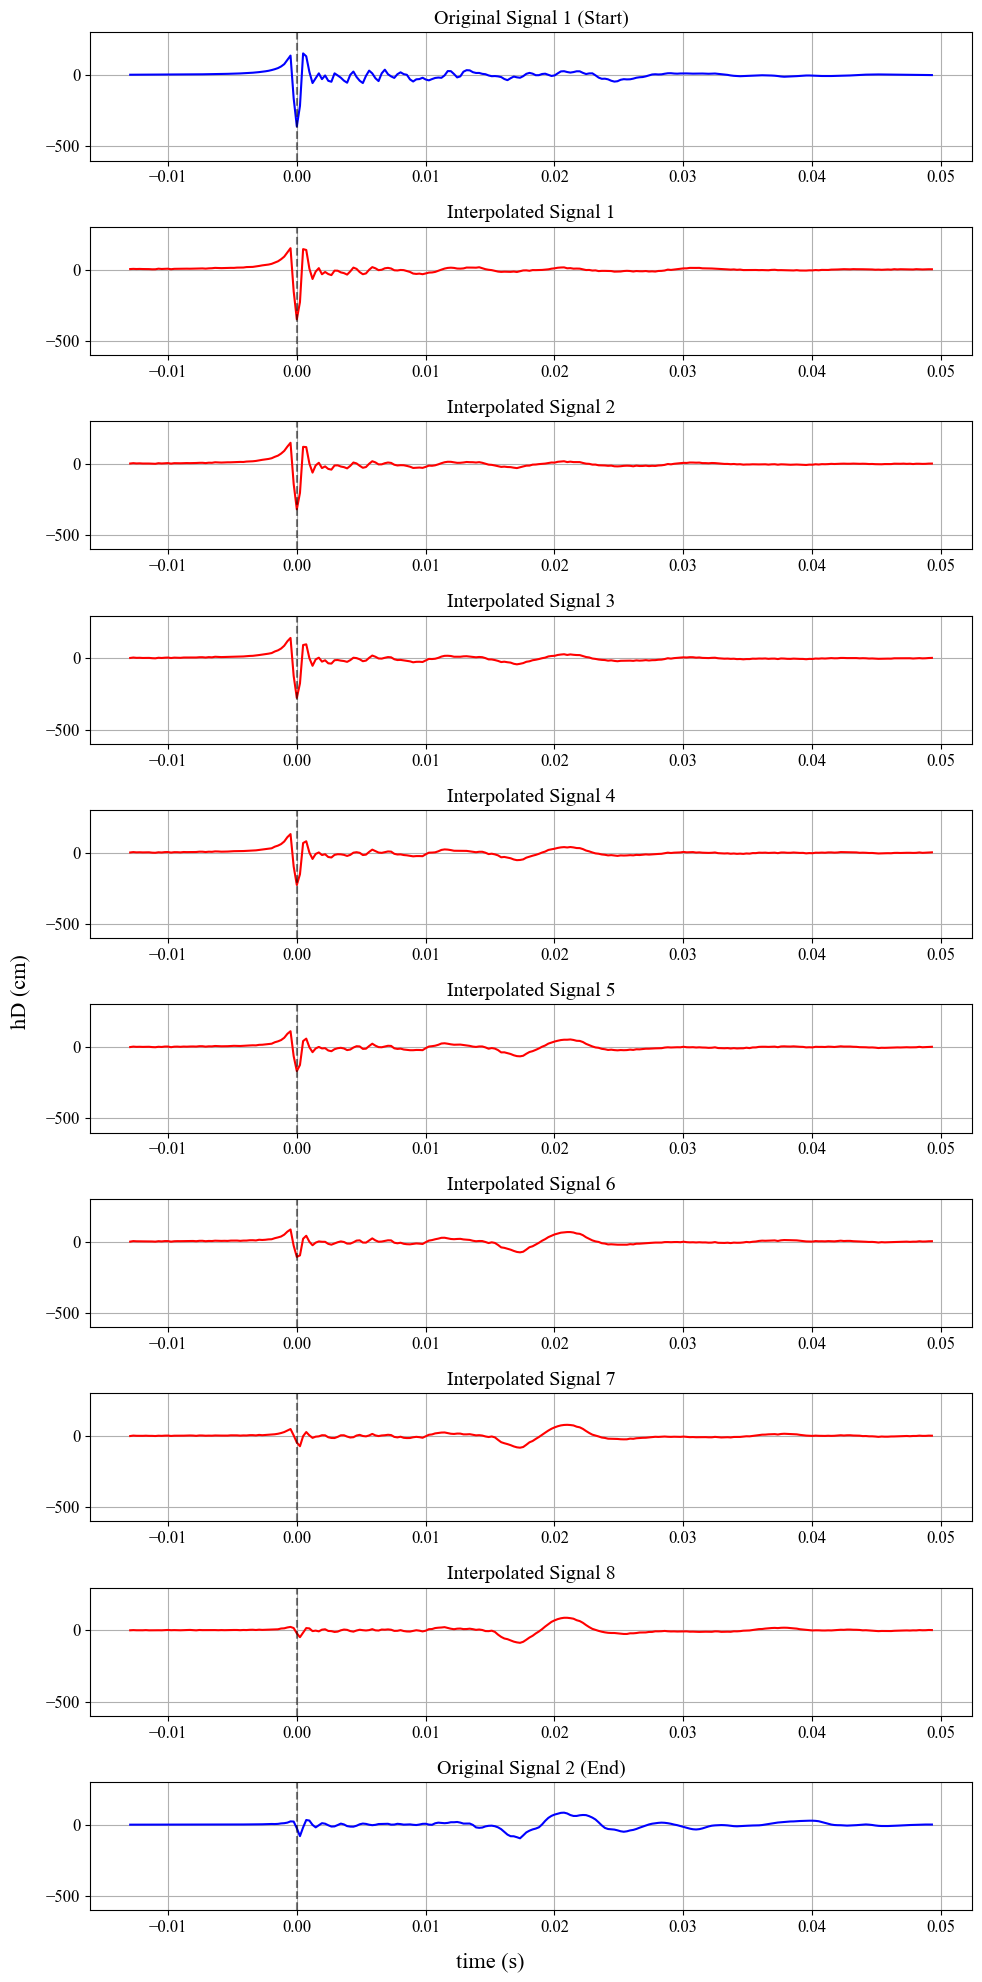

Training:  14%|█▍        | 71/512 [01:01<07:14,  1.02it/s]

Epoch 71, Train Loss: 34.6340, Val Loss: 37.6759


Training:  14%|█▍        | 72/512 [01:02<06:40,  1.10it/s]

Epoch 72, Train Loss: 34.3077, Val Loss: 40.4074


Training:  14%|█▍        | 73/512 [01:03<06:05,  1.20it/s]

Epoch 73, Train Loss: 34.2920, Val Loss: 38.4240


Training:  14%|█▍        | 74/512 [01:03<05:46,  1.27it/s]

Epoch 74, Train Loss: 34.2107, Val Loss: 39.5670


Training:  15%|█▍        | 75/512 [01:04<05:30,  1.32it/s]

Epoch 75, Train Loss: 34.2256, Val Loss: 38.1384


Training:  15%|█▍        | 76/512 [01:05<05:22,  1.35it/s]

Epoch 76, Train Loss: 33.8233, Val Loss: 38.8272


Training:  15%|█▌        | 77/512 [01:05<05:13,  1.39it/s]

Epoch 77, Train Loss: 34.4015, Val Loss: 38.6399


Training:  15%|█▌        | 78/512 [01:06<05:12,  1.39it/s]

Epoch 78, Train Loss: 34.0768, Val Loss: 38.8570


Training:  15%|█▌        | 79/512 [01:07<05:04,  1.42it/s]

Epoch 79, Train Loss: 33.8780, Val Loss: 38.7709


Training:  15%|█▌        | 79/512 [01:08<05:04,  1.42it/s]

Epoch 80, Train Loss: 33.7457, Val Loss: 38.2651


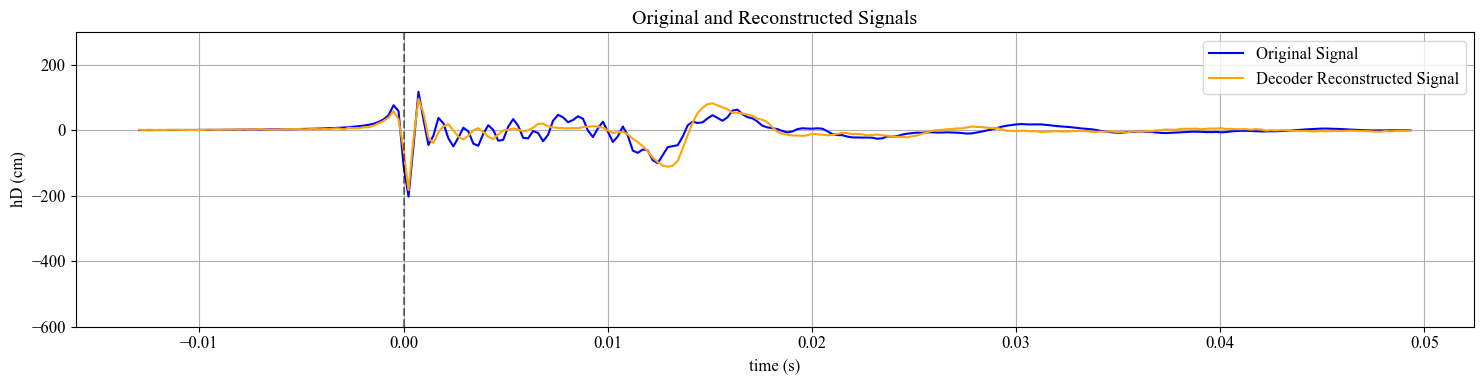

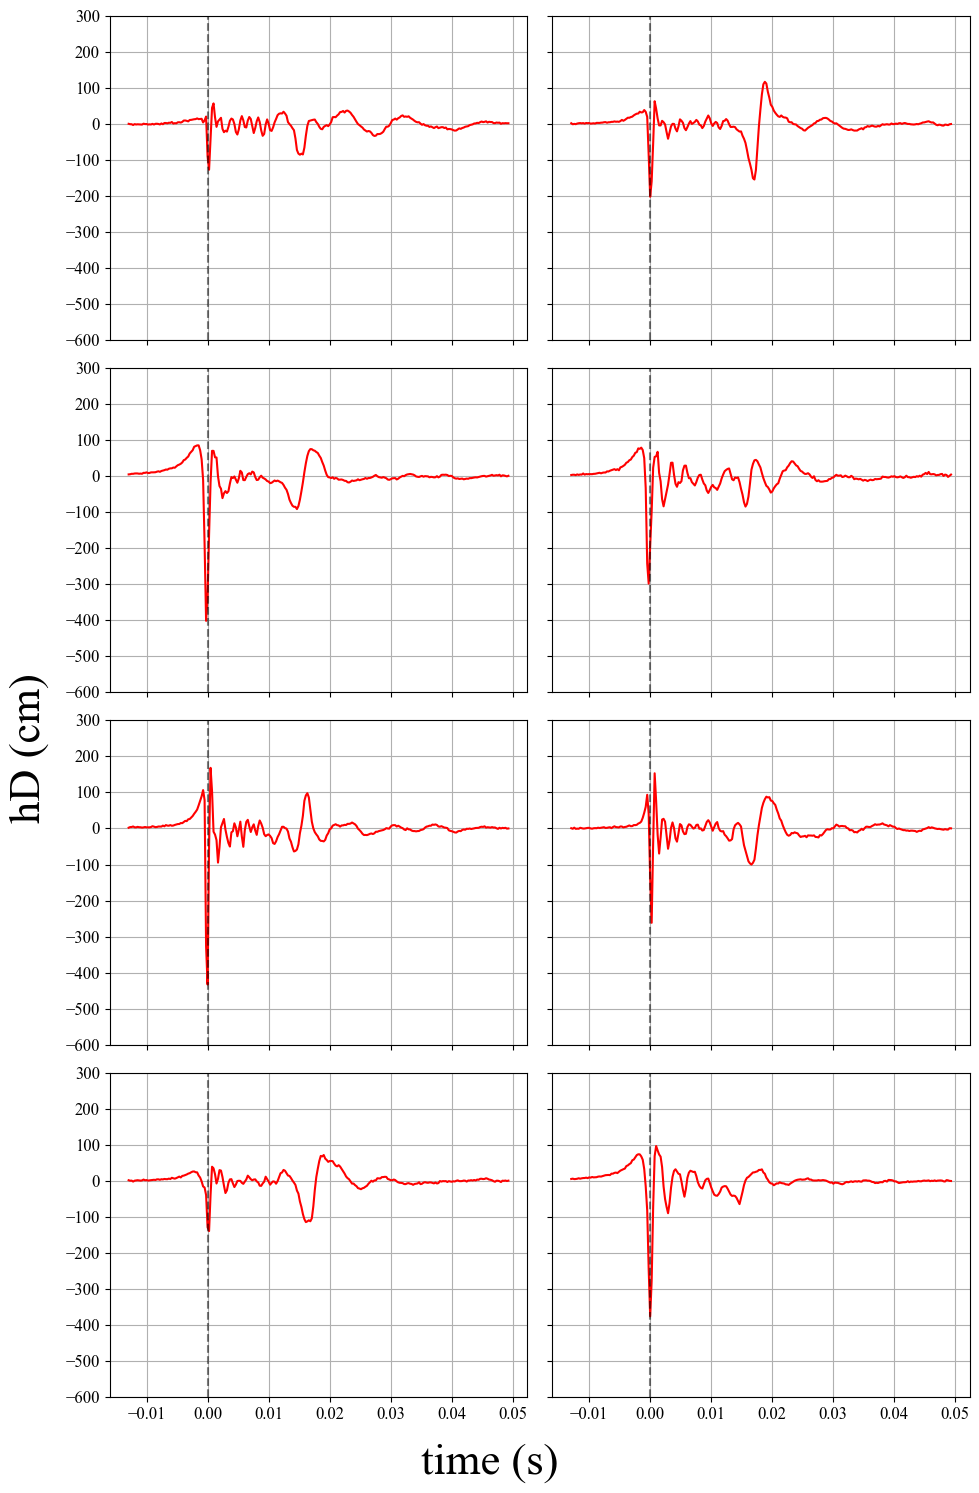

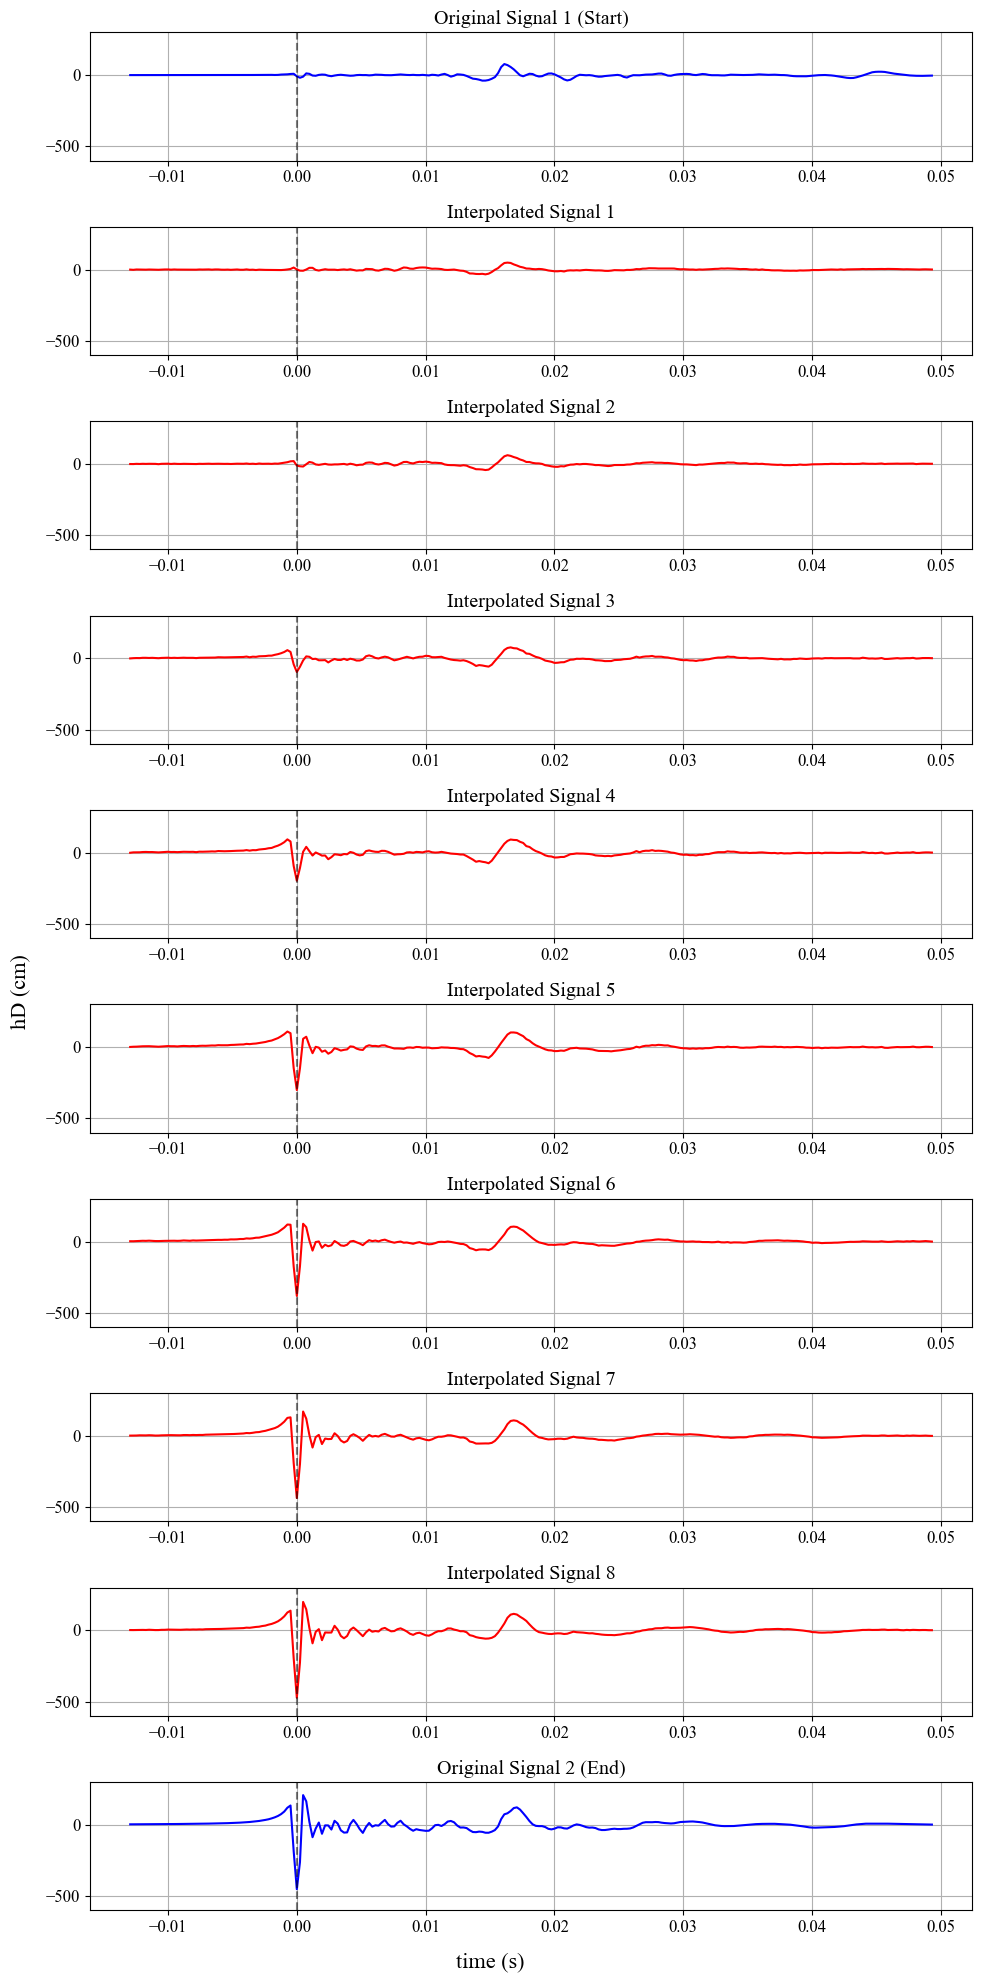

Training:  16%|█▌        | 81/512 [01:09<06:52,  1.04it/s]

Epoch 81, Train Loss: 33.4404, Val Loss: 37.9814


Training:  16%|█▌        | 82/512 [01:10<06:16,  1.14it/s]

Epoch 82, Train Loss: 33.8351, Val Loss: 37.9574


Training:  16%|█▌        | 83/512 [01:11<05:50,  1.22it/s]

Epoch 83, Train Loss: 33.0959, Val Loss: 38.4215


Training:  16%|█▋        | 84/512 [01:11<05:27,  1.31it/s]

Epoch 84, Train Loss: 33.4222, Val Loss: 38.0958


Training:  17%|█▋        | 85/512 [01:12<05:17,  1.35it/s]

Epoch 85, Train Loss: 33.1696, Val Loss: 39.0529


Training:  17%|█▋        | 86/512 [01:13<05:06,  1.39it/s]

Epoch 86, Train Loss: 33.5334, Val Loss: 38.4023


Training:  17%|█▋        | 87/512 [01:14<05:02,  1.40it/s]

Epoch 87, Train Loss: 33.3045, Val Loss: 39.2871


Training:  17%|█▋        | 88/512 [01:14<04:53,  1.44it/s]

Epoch 88, Train Loss: 33.0901, Val Loss: 37.1206


Training:  17%|█▋        | 89/512 [01:15<04:54,  1.44it/s]

Epoch 89, Train Loss: 32.6750, Val Loss: 37.6611


Training:  17%|█▋        | 89/512 [01:16<04:54,  1.44it/s]

Epoch 90, Train Loss: 33.1447, Val Loss: 38.7955


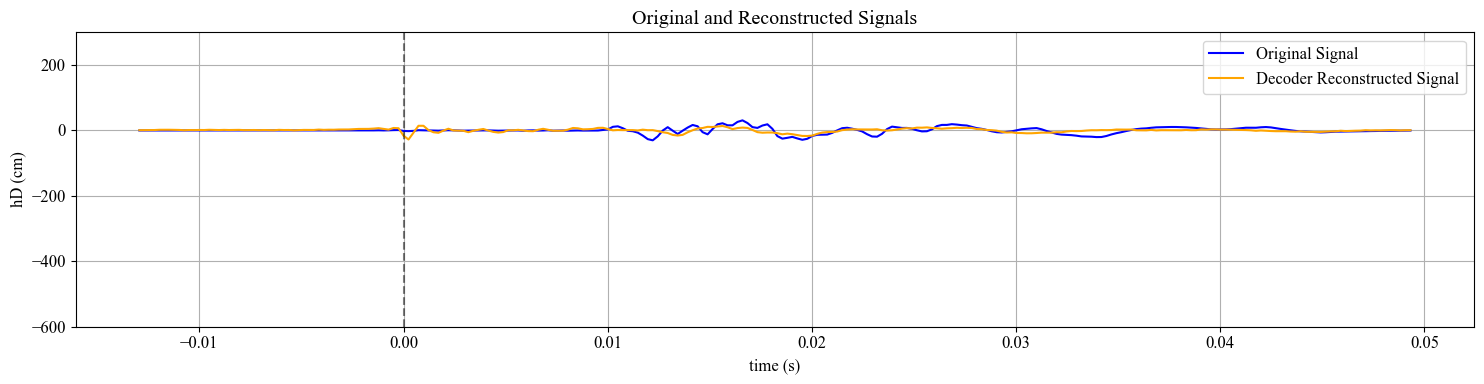

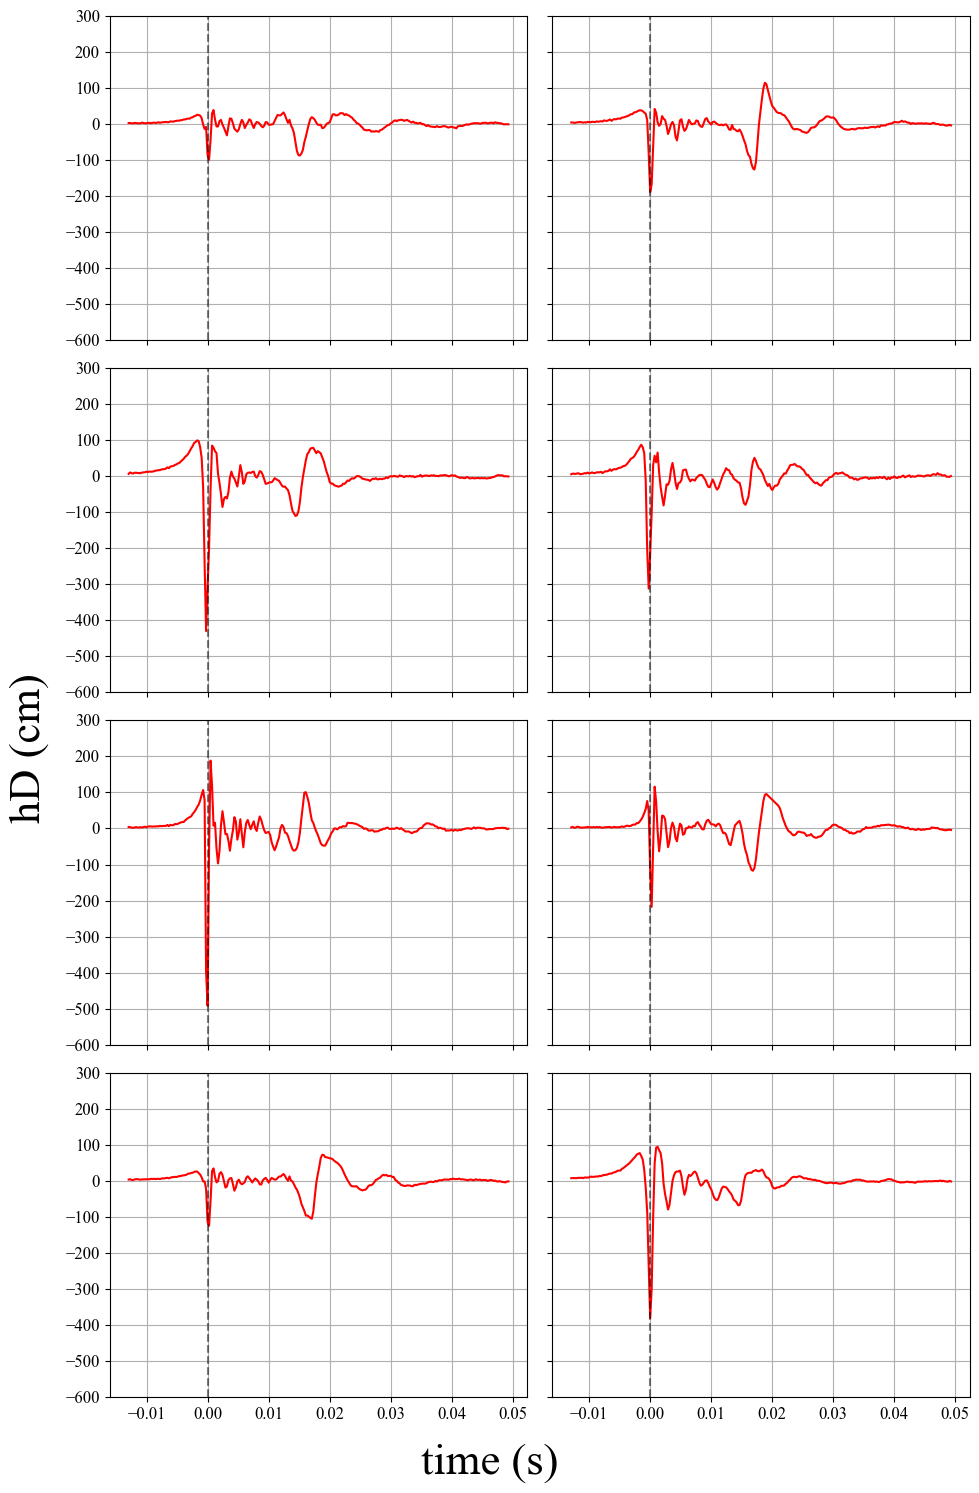

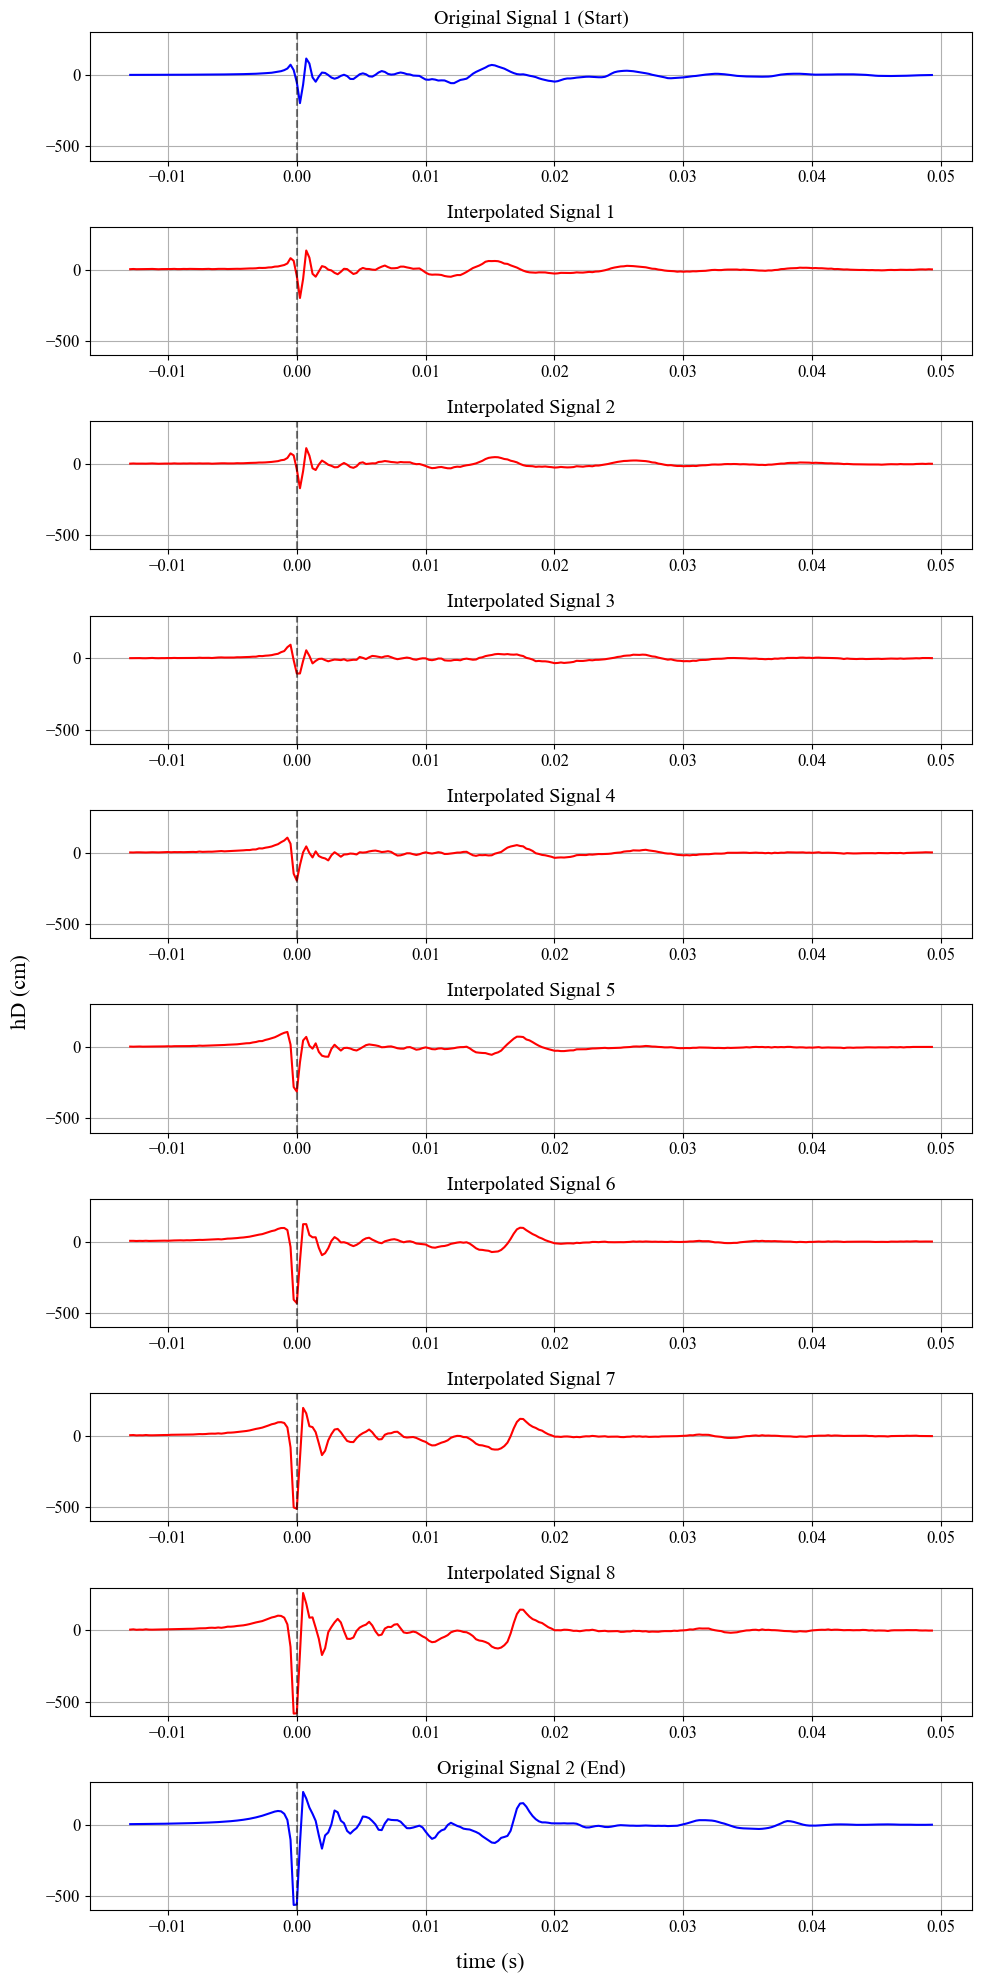

Training:  18%|█▊        | 91/512 [01:17<06:35,  1.06it/s]

Epoch 91, Train Loss: 32.9800, Val Loss: 37.4477


Training:  18%|█▊        | 92/512 [01:18<06:04,  1.15it/s]

Epoch 92, Train Loss: 33.0029, Val Loss: 37.0178


Training:  18%|█▊        | 93/512 [01:19<05:35,  1.25it/s]

Epoch 93, Train Loss: 32.2738, Val Loss: 37.4140


Training:  18%|█▊        | 94/512 [01:19<05:20,  1.30it/s]

Epoch 94, Train Loss: 32.5484, Val Loss: 36.7941


Training:  19%|█▊        | 95/512 [01:20<05:11,  1.34it/s]

Epoch 95, Train Loss: 32.0270, Val Loss: 37.7666


Training:  19%|█▉        | 96/512 [01:21<04:59,  1.39it/s]

Epoch 96, Train Loss: 32.3272, Val Loss: 36.5078


Training:  19%|█▉        | 97/512 [01:22<04:56,  1.40it/s]

Epoch 97, Train Loss: 32.3746, Val Loss: 37.7115


Training:  19%|█▉        | 98/512 [01:22<04:53,  1.41it/s]

Epoch 98, Train Loss: 32.0207, Val Loss: 37.1791


Training:  19%|█▉        | 99/512 [01:23<04:48,  1.43it/s]

Epoch 99, Train Loss: 32.1094, Val Loss: 36.3061


Training:  19%|█▉        | 99/512 [01:24<04:48,  1.43it/s]

Epoch 100, Train Loss: 32.0307, Val Loss: 37.1108


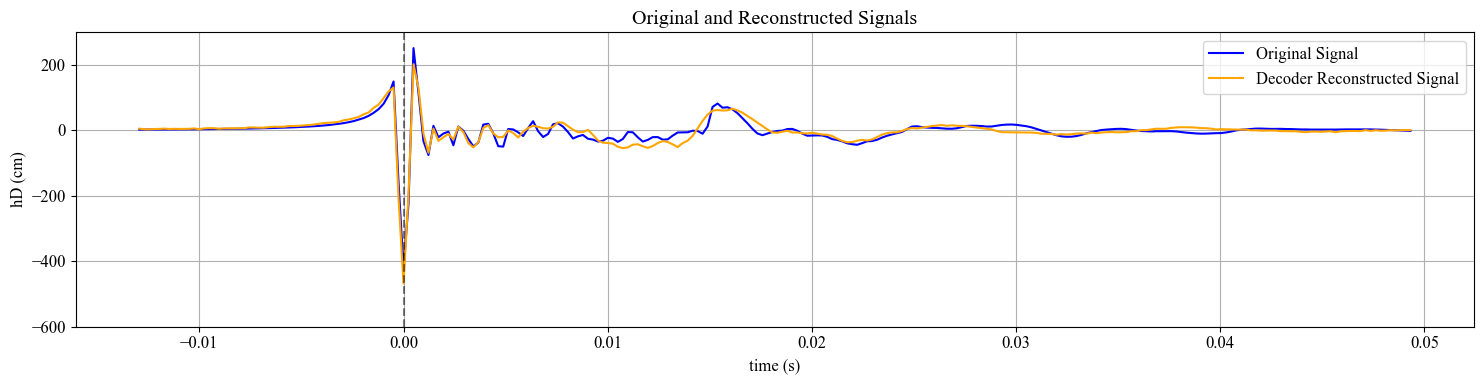

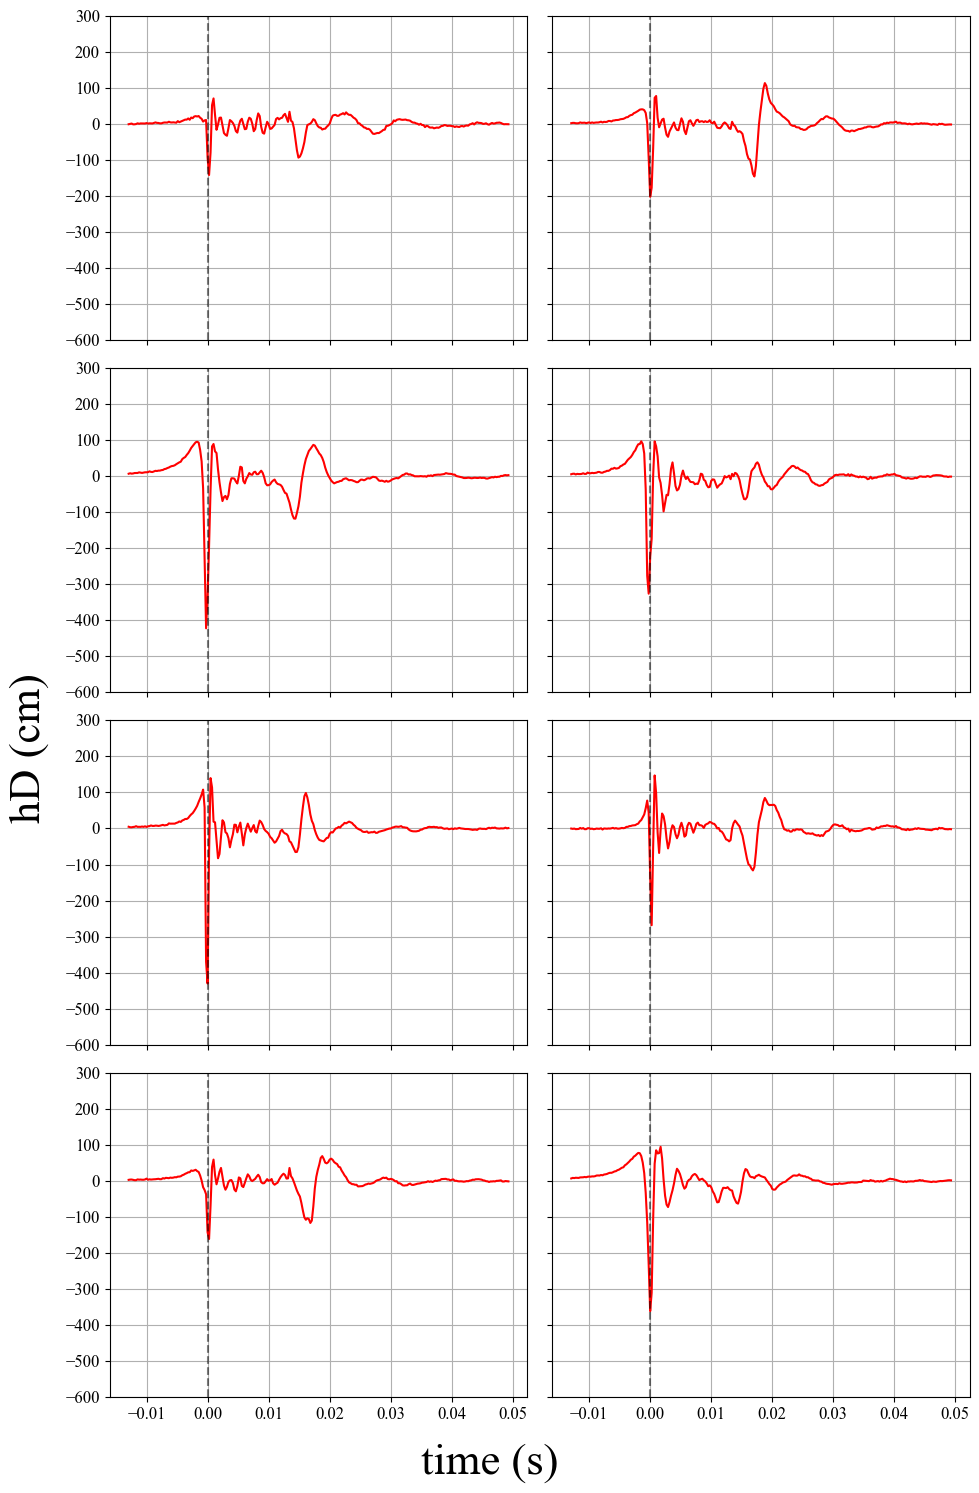

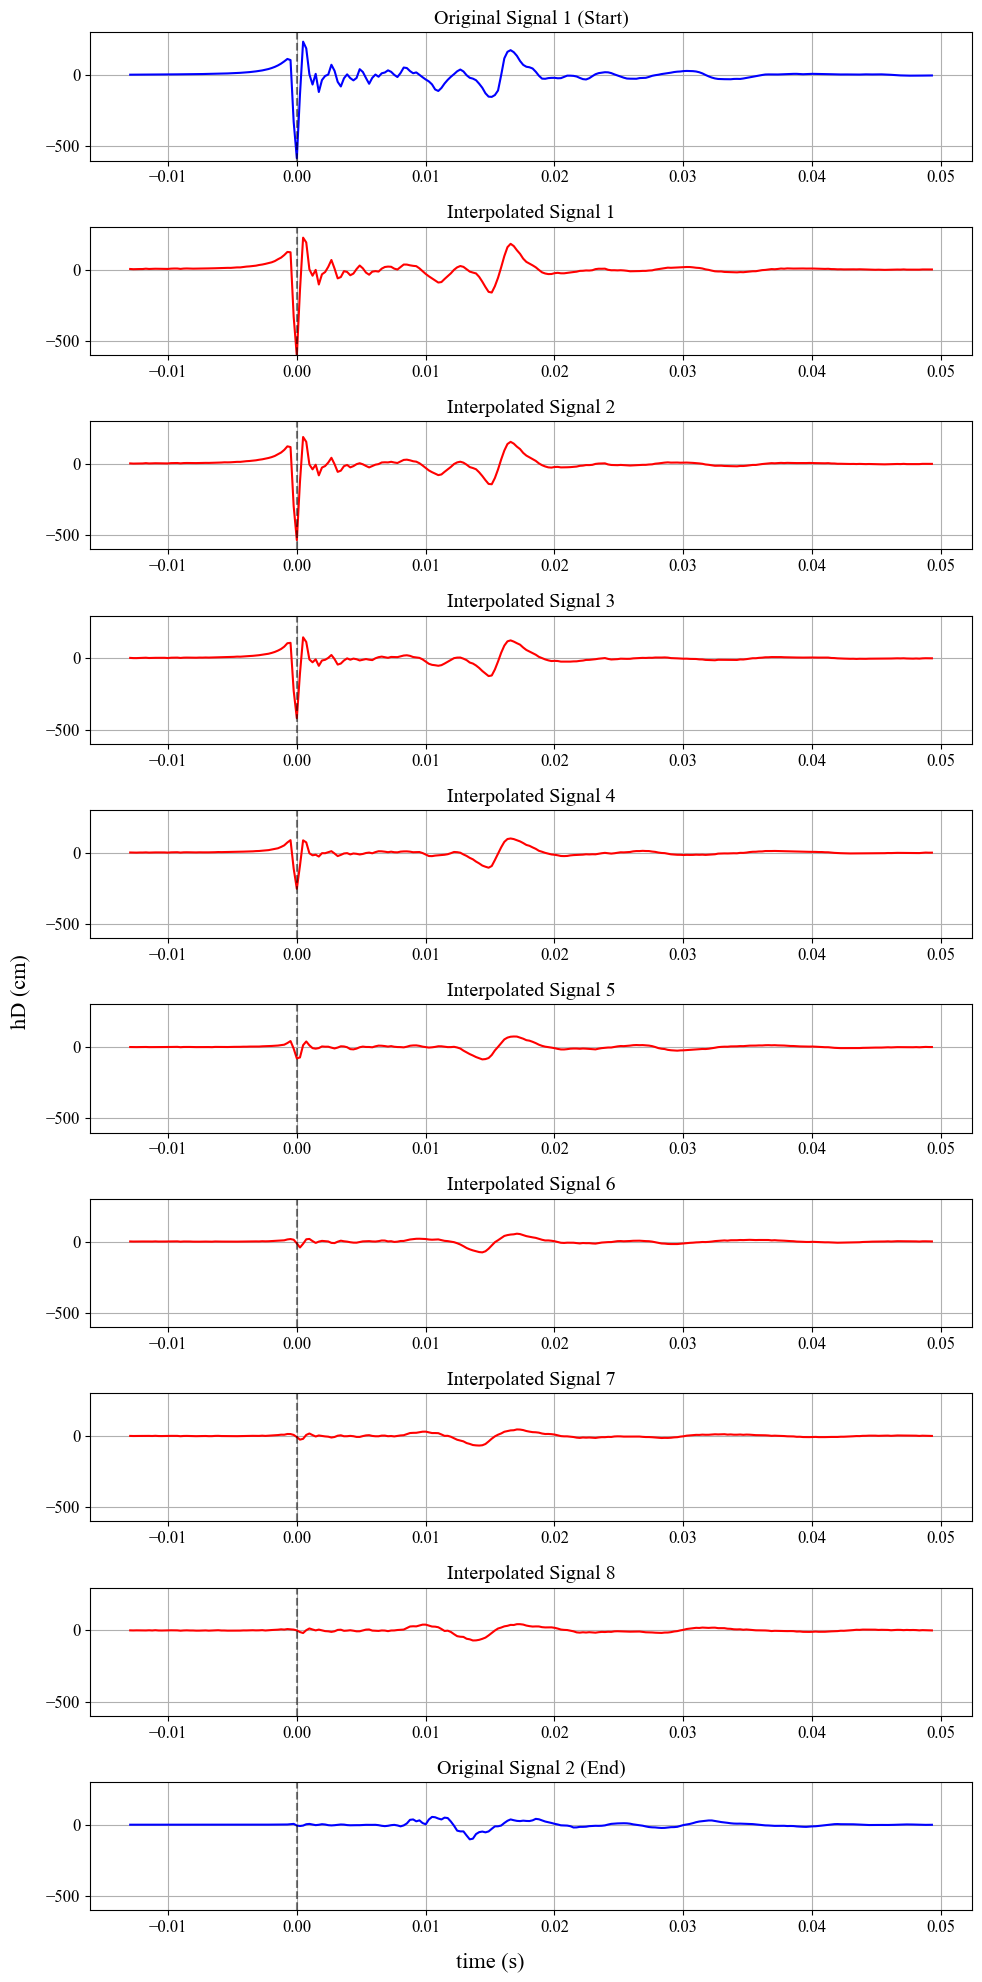

Training:  20%|█▉        | 101/512 [01:26<06:32,  1.05it/s]

Epoch 101, Train Loss: 31.8084, Val Loss: 37.3282


Training:  20%|█▉        | 102/512 [01:26<06:02,  1.13it/s]

Epoch 102, Train Loss: 31.4413, Val Loss: 36.1089


Training:  20%|██        | 103/512 [01:27<05:33,  1.23it/s]

Epoch 103, Train Loss: 32.0617, Val Loss: 37.8975


Training:  20%|██        | 104/512 [01:28<05:20,  1.27it/s]

Epoch 104, Train Loss: 32.0239, Val Loss: 36.8882


In [ ]:
print("Start training VAE...")
avg_total_losses = []
avg_reproduction_losses = []
avg_kld_losses = []

avg_total_losses_validation = []
avg_reproduction_losses_validation = []
avg_kld_losses_validation = []

noise = torch.randn(batch_size, latent_dim).to(DEVICE)

# validation data for validation
validation_data = []
for data in validation_dataloader:
    validation_data.append(data.to(DEVICE))
validation_data = torch.cat(validation_data, dim=0)

for epoch in tqdm(range(epochs), desc="Training"):
    overall_total_loss = 0
    overall_reproduction_loss = 0
    overall_kld_loss = 0

    overall_total_loss_validation = 0
    overall_reproduction_loss_validation = 0
    overall_kld_loss_validation = 0

    total_samples = 0

    for batch_idx, x in enumerate(train_dataloader, 0):
        model.train()
        x = x.view(x.size(0), -1)  # Reshape to (batch_size, 256) if needed
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        total_loss, reproduction_loss, KLD = loss_function(x, x_hat, mean, log_var)
        
        overall_total_loss += total_loss.item()
        overall_reproduction_loss += reproduction_loss.item()
        overall_kld_loss += KLD.item()
        total_samples += x.size(0)

        total_loss.backward()
        optimizer.step()

        # validation losses
        model.eval()
        with torch.no_grad():
            x_validation = validation_data
            x_validation = x_validation.view(x_validation.size(0), -1).to(DEVICE)
            x_hat_validation, mean_validation, log_var_validation = model(x_validation)
            total_loss_validation, reproduction_loss_validation, kld_loss_validation = loss_function(x_validation, x_hat_validation, mean_validation, log_var_validation)

    # summarise training losses
    avg_total_loss = overall_total_loss / total_samples
    avg_reproduction_loss = overall_reproduction_loss / total_samples
    avg_kld_loss = overall_kld_loss / total_samples

    avg_total_losses.append(avg_total_loss)
    avg_reproduction_losses.append(avg_reproduction_loss)
    avg_kld_losses.append(avg_kld_loss)

    # summarise validation losses
    avg_total_loss_validation = total_loss_validation.item() / x_validation.size(0)
    avg_reproduction_loss_validation = reproduction_loss_validation.item() / x_validation.size(0)
    avg_kld_loss_validation = kld_loss_validation.item() / x_validation.size(0)

    avg_total_losses_validation.append(avg_total_loss_validation)
    avg_reproduction_losses_validation.append(avg_reproduction_loss_validation)
    avg_kld_losses_validation.append(avg_kld_loss_validation)

    tqdm.write(f'Epoch {epoch+1}, Train Loss: {avg_total_loss:.4f}, Val Loss: {avg_total_loss_validation:.4f}')

    if (epoch + 1) % 10 == 0:
        x = x.cpu().detach()
        x_hat = x_hat.cpu().detach()
        plot_reconstruction(x[0], x_hat[0], max_value=train_dataset.max_value)

        with torch.no_grad():
            generated_signals = model.decoder(noise).cpu().detach().numpy()
        
        plot_waveform_grid(signals=generated_signals, max_value=train_dataset.max_value)

        idx1 = torch.randint(0, x.size(0), (1,)).item()
        idx2 = idx1

        while idx2 == idx1: # ensures we don't sample the same signal
            idx2 = torch.randint(0, x.size(0), (1,)).item()

        signal_1 = x[idx1].to(DEVICE)
        signal_2 = x[idx2].to(DEVICE)
        
        plot_latent_morphs(model, signal_1, signal_2, max_value=train_dataset.max_value, steps=8)

print("Training finished!")
model.eval()

### Training and Validation Loss

In [ ]:
plot_training_validation_loss(avg_total_losses, avg_total_losses_validation)

In [ ]:
plot_individual_loss(avg_total_losses, avg_reproduction_losses, avg_kld_losses)

### Generated XXXXX Signals

In [ ]:
number_of_signals = 10000
noise = torch.randn(number_of_signals, latent_dim).to(DEVICE)

start_time = time.time()
with torch.no_grad():
    generated_signals = model.decoder(noise).cpu().detach().numpy()
end_time = time.time()

execution_time = end_time - start_time
print("Execution Time:", execution_time, "seconds")

In [ ]:
generated_signals_transpose = np.empty((x_length, 0))

for i in range(number_of_signals):
    y = generated_signals[i, :].flatten()
    y = y * train_dataset.max_value
    y = y.reshape(-1, 1)
    
    generated_signals_transpose = np.concatenate((generated_signals_transpose, y), axis=1)

### Plot Generated Distribution

In [ ]:
plot_signal_distribution(generated_signals_transpose, generated=True)

### Morph Animation

In [ ]:
def animate_latent_morphs(
    model: VAE, 
    signal_1: torch.Tensor,
    signal_2: torch.Tensor,
    max_value: float, 
    steps=10,
    interval=200,
    save_path=None
):
    model.eval()

    with torch.no_grad():
        mean_1, _ = model.encoder(signal_1)
        mean_2, _ = model.encoder(signal_2)

        interpolated_latents = [mean_1 * (1 - alpha) + mean_2 * alpha for alpha in np.linspace(0, 1, steps)]
        morphed_signals = [model.decoder(latent).cpu().detach().numpy() for latent in interpolated_latents]

    fig, ax = plt.subplots(figsize=(10, 5))

    # X-axis values (shared across all plots)
    x_vals = [i / 4096 for i in range(0, 256)]
    x_vals = [value - (53 / 4096) for value in x_vals]

    # Initialize the plot
    line, = ax.plot([], [], color="red")
    ax.set_xlim(min(x_vals), max(x_vals))
    ax.set_ylim(-600, 300)
    ax.axvline(x=0, color="black", linestyle="--", alpha=0.5)
    ax.grid(True)
    ax.set_xlabel('time (s)', fontsize=16)
    ax.set_ylabel('hD (cm)', fontsize=16)

    def init():
        line.set_data([], [])
        return line,

    def update(frame):
        y_interp = morphed_signals[frame].flatten() * max_value
        line.set_data(x_vals, y_interp)
        ax.set_title(f"Interpolated Signal {frame + 1}")
        return line,

    ani = animation.FuncAnimation(fig, update, frames=range(steps), init_func=init, blit=True, interval=interval)

    if save_path:
        ani.save(save_path, writer='imagemagick', fps=30)

    plt.show()

# Example usage
animate_latent_morphs(model, signal_1, signal_2, train_dataset.max_value, steps=100, interval=200, save_path="morph_animation.gif")

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

def animate_latent_morphs(
    model,  # Assuming model is a VAE instance
    signal_1: torch.Tensor,
    signal_2: torch.Tensor,
    max_value: float, 
    train_dataset,
    steps=10,
    interval=200,
    save_path=None
):
    model.eval()

    with torch.no_grad():
        mean_1, _ = model.encoder(signal_1)
        mean_2, _ = model.encoder(signal_2)

        # Forward and backward interpolation
        forward_interpolated = [mean_1 * (1 - alpha) + mean_2 * alpha for alpha in np.linspace(0, 1, steps)]
        backward_interpolated = [mean_2 * (1 - alpha) + mean_1 * alpha for alpha in np.linspace(0, 1, steps)]
        interpolated_latents = forward_interpolated + backward_interpolated
        morphed_signals = [model.decoder(latent).cpu().detach().numpy() for latent in interpolated_latents]

        # Compute the posterior distribution
        all_means = []
        for data in train_dataset:
            data = torch.tensor(data).to(model.DEVICE)
            mean, _ = model.encoder(data)
            all_means.append(mean.cpu().numpy())
        all_means = np.concatenate(all_means, axis=0)

    fig = plt.figure(figsize=(10, 17))  # Adjust the figure size for vertical stacking

    # Create 3D plot for latent space
    ax_latent = fig.add_subplot(211, projection='3d')  # First plot (top) in vertical layout
    ax_latent.scatter(all_means[:, 0], all_means[:, 1], all_means[:, 2], color='gray', alpha=0.2, label='Posterior Distribution')
    ax_latent.scatter(mean_1[0].cpu().numpy(), mean_1[1].cpu().numpy(), mean_1[2].cpu().numpy(), color='blue', s=50, label='Signal 1')
    ax_latent.scatter(mean_2[0].cpu().numpy(), mean_2[1].cpu().numpy(), mean_2[2].cpu().numpy(), color='green', s=50, label='Signal 2')
    ax_latent.plot([mean_1[0].cpu().numpy(), mean_2[0].cpu().numpy()],
                   [mean_1[1].cpu().numpy(), mean_2[1].cpu().numpy()],
                   [mean_1[2].cpu().numpy(), mean_2[2].cpu().numpy()], color='red', linestyle='--', label='Interpolation Path', linewidth=2)
    moving_point, = ax_latent.plot([], [], [], 'ro', markersize=7, label='Interpolated Point')
    # ax_latent.set_title('Latent Space Interpolation')
    ax_latent.set_xlabel('Latent Dim 1')
    ax_latent.set_ylabel('Latent Dim 2')
    ax_latent.set_zlabel('Latent Dim 3')
    # ax_latent.legend()

    # Create plot for signal morphing
    ax_signal = fig.add_subplot(212)  # Second plot (bottom) in vertical layout

    # X-axis values (shared across all plots)
    x_vals = [i / 4096 for i in range(0, 256)]
    x_vals = [value - (53 / 4096) for value in x_vals]

    # Initialize the plot
    line, = ax_signal.plot([], [], color="red")
    ax_signal.set_xlim(min(x_vals), max(x_vals))
    ax_signal.set_ylim(-600, 300)
    ax_signal.axvline(x=0, color="black", linestyle="--", alpha=0.5)
    ax_signal.grid(True)
    ax_signal.set_xlabel('time (s)', fontsize=16)
    ax_signal.set_ylabel('hD (cm)', fontsize=16)

    def init():
        line.set_data([], [])
        moving_point.set_data([], [])
        moving_point.set_3d_properties([])
        return line, moving_point

    def update(frame):
        y_interp = morphed_signals[frame].flatten() * max_value
        line.set_data(x_vals, y_interp)
        # ax_signal.set_title(f"Interpolated Signal {frame + 1}")

        # Update the moving point in the latent space
        latent_point = interpolated_latents[frame].cpu().numpy()
        moving_point.set_data(latent_point[0], latent_point[1])
        moving_point.set_3d_properties(latent_point[2])
        return line, moving_point

    ani = animation.FuncAnimation(fig, update, frames=len(interpolated_latents), init_func=init, blit=True, interval=interval, repeat=True)

    if save_path:
        ani.save(save_path, writer='imagemagick', fps=30)

    plt.show()

# Example usage
animate_latent_morphs(model, signal_1, signal_2, train_dataset.max_value, train_dataset, steps=100, interval=200, save_path="morph_animation.gif")
